In [1]:
%reload_ext autoreload
%autoreload 2

In [87]:

import warnings
from pathlib import Path
from typing import Any
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, precision_recall_curve, f1_score, classification_report, auc
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, IsolationForest
from sklearn.base import BaseEstimator, ClassifierMixin

import optuna
import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler, AllKNN, NearMiss

from fraud_detection.utils import load_pickle_dataset, save_pickle_dataset, get_pipeline, save_model, load_model, display_model_result, plot_confusion_matrix
from fraud_detection.config import DATA_CSV_PATH, DATA_PICKLE_PATH, SRC_DIR

warnings.filterwarnings('ignore')
%matplotlib inline

MAX_TRIAL=50
SEED=42

### Load Dataset

In [3]:
if Path(DATA_PICKLE_PATH).exists():
    print("⏳ Load dataset from pickle")
    data = load_pickle_dataset()
    print("✅ Data loaded")
else:
    print("⏳ Loading dataset from csv")
    data = pd.read_csv(f"{DATA_CSV_PATH}")
    print("✅ Data loaded")
    
    print("⏳ Saving dataset to pickle file")
    save_pickle_dataset(data)
    print("✅ Data Saved")

⏳ Load dataset from pickle
✅ Data loaded


In [4]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Prepare Data

In [5]:
data.drop('isFlaggedFraud', axis=1, inplace=True)

In [6]:
X = data.drop(columns=['step', 'nameOrig', 'nameDest', 'isFraud'])
y = data['isFraud']

In [7]:
# Data Without Sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4771965, 6), (1590655, 6), (4771965,), (1590655,))

In [8]:
smote = SMOTE(random_state=SEED)
smote

SMOTE(random_state=42)

### Model Definition

In [9]:

# Preprocess
def preprocess() -> Pipeline:
    category_transformer = OneHotEncoder(drop='if_binary', sparse_output=False)
    numeric_transformer = make_pipeline(StandardScaler())
    
    column_transformer = make_column_transformer(
		(category_transformer, make_column_selector(dtype_include=[object, bool])),
		(numeric_transformer, make_column_selector(dtype_exclude=[object, bool])),
		remainder='passthrough'
	)

    return  make_pipeline(column_transformer)


# Model creation
def build_model(model, X: np.ndarray, y: np.ndarray, *args, **kwargs) -> Pipeline:
    if kwargs['resampled']:
        X_train_transformed = preprocess().fit_transform(X)
        smote = SMOTE(random_state=SEED)
        X_resampled, y_resampled = smote.fit_resample(X_train_transformed, y)
        print('#️⃣ Before sampling SMOTE:', Counter(y))
        print('#️⃣ After sampling SMOTE:', Counter(y_resampled))
        
        pipeline = get_pipeline(model, None)
        pipeline.fit(X_resampled, y_resampled)
    else:
        pipeline = get_pipeline(model, preprocess())
        pipeline.fit(X, y)
    
    return pipeline


# Display performance
def display_performance(model, X: np.ndarray, y: np.ndarray, *args, **kwargs) -> pd.DataFrame:
    accuracy= []
    recall =[]
    roc_auc= []
    precision = []
    f1score = []
    
    y_pred = model.predict(X)
    
    accuracy.append(round(accuracy_score(y, y_pred),4))
    recall.append(round(recall_score(y, y_pred),4))
    roc_auc.append(round(roc_auc_score(y, y_pred),4))
    precision.append(round(precision_score(y, y_pred),4))
    f1score.append(round(f1_score(y, y_pred), 4))
    
    model_names = []
    model_names.append(kwargs['model_name'])

    return pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision, 'F1 Score': f1score}, index=model_names)

### Base Model: *XGBoost* & *Random Forest*

In [11]:
X_train_transformed = preprocess().fit_transform(X_train)
X_test_transformed = preprocess().fit_transform(X_test)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

In [10]:
# XGBoost
xgb_base_model = XGBClassifier(random_state=SEED)
xgb_base = build_model(xgb_base_model, X_train, y_train, resampled=False)
xgb_base_performance = display_performance(xgb_base, X_test, y_test, model_name='XGBoost_base')
xgb_base_performance

[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   1.8s
[Pipeline] ..... (step 2 of 2) Processing xgbclassifier, total=   6.8s


,Accuracy,Recall,Roc_Auc,Precision,F1 Score
XGBoost_base,0.9997,0.7681,0.884,0.9534,0.8508


In [12]:
# RandomForest
rf_base = build_model(RandomForestClassifier(random_state=SEED), X_train, y_train, resampled=False)
rf_base_performance = display_performance(rf_base, X_test, y_test, model_name='RandomForest_base')
rf_base_performance

[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   1.8s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total=11.7min


,Accuracy,Recall,Roc_Auc,Precision,F1 Score
RandomForest_base,0.9997,0.7764,0.8882,0.9666,0.8612


In [13]:
# RandomForest with SMOTE sampling
rf_base_smote = build_model(RandomForestClassifier(random_state=SEED), X_train, y_train, resampled=True)
rf_base_smote_performance = display_performance(rf_base_smote, X_test_transformed, y_test, model_name='RandomForest_smote_base') 
rf_base_smote_performance

#️⃣ Before sampling SMOTE: Counter({0: 4765805, 1: 6160})
#️⃣ After sampling SMOTE: Counter({0: 4765805, 1: 4765805})


,Accuracy,Recall,Roc_Auc,Precision,F1 Score
RandomForest_smote_base,0.9989,0.1656,0.5828,0.9827,0.2835


In [82]:
X_transformed = preprocess().fit_transform(X)

In [89]:
under_sample = NearMiss()
under_sample

NearMiss()

In [84]:
X_resampled_under, y_resampled_under = NearMiss().fit_resample(X_transformed, y)

((6352355, 10), (6352355,))

In [90]:
print(f"Before under sampling: {Counter(y)}")
print(f"After under sampling: {Counter(y_resampled_under)}")

Before under sampling: Counter({0: 6354407, 1: 8213})
After under sampling: Counter({0: 6344142, 1: 8213})


In [85]:
Counter(y_resampled_under)

Counter({0: 6344142, 1: 8213})

In [ ]:
# RandomForest with under sampling
rf_base_under_sampling = build_model(RandomForestClassifier())

In [15]:
# Model Performance comparaison
performance_summary = pd.concat([xgb_base_performance, rf_base_performance, rf_base_smote_performance], axis=0)
performance_summary

,Accuracy,Recall,Roc_Auc,Precision,F1 Score
XGBoost_base,0.9997,0.7681,0.8840,0.9534,0.8508
RandomForest_base,0.9997,0.7764,0.8882,0.9666,0.8612
RandomForest_smote_base,0.9989,0.1656,0.5828,0.9827,0.2835


### Tuning Hyperparameter and Cross-Validation With **optuna**

In [42]:
def xgb_objective(trial: optuna.Trial) -> float:
    params = {
		'n_estimators': trial.suggest_int('n_estimators', 100, 300, step=50),
		'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.7),
		'max_depth': trial.suggest_int('max_depth', 3, 7),
		'subsample': trial.suggest_float('subsample', 0.8, 1.0),
		'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
		'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, int(y_train.value_counts()[0] / y_train.value_counts()[1])),
		'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.5, step=.1),
		'reg_lambda': trial.suggest_float('reg_lambda', 1, 2, step=.5)
	}
    
    # prune_error = 'validation_0-auc'
    # pruning_callback = optuna.integration.XGBoostPruningCallback(trial, prune_error)
    
    model = XGBClassifier(
        random_state=SEED,
		eval_metric='auc',
		verbosity=0,
        use_label_encoder=False,
        enable_categorical=True,
        early_stopping_rounds=30,
        **params,
    )
    
    fit_params = {
		'eval_set': [(X_test_transformed, y_test)]
	}
    score = cross_val_score(model,
                            X_train_transformed,
                            y_train,
                            n_jobs=-1,
                            cv=5,
                            scoring='roc_auc',
                            fit_params=fit_params).mean()
    
    if trial.should_prune():
        raise optuna.TrialPruned()

    return score

In [40]:
MAX_TRIAL = 100
def tune_model(objective: callable, *args, **kwargs) -> optuna.Study:
    def max_trial_callback(study, trial):
        n_complete = len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE or t.state == optuna.trial.TrialState.RUNNING])
        if n_complete >= MAX_TRIAL:
            study.stop()
            
    study = optuna.create_study(
        direction='maximize',
        study_name='fraud-detection-study',
        sampler=optuna.samplers.TPESampler(),
        storage='sqlite:///fraud_detection_study.sqlite3',
        load_if_exists=True)

    study.optimize(
        objective,
        callbacks=[max_trial_callback], n_jobs=-1)
    
    return study

In [43]:
xgb_study = tune_model(xgb_objective)

[I 2024-06-25 01:04:47,757] Using an existing study with name 'fraud-detection-study' instead of creating a new one.


[0]	validation_0-auc:0.84887
[0]	validation_0-auc:0.84627
[0]	validation_0-auc:0.84931
[0]	validation_0-auc:0.84890
[0]	validation_0-auc:0.84887
[1]	validation_0-auc:0.88467
[1]	validation_0-auc:0.88825
[1]	validation_0-auc:0.88615
[1]	validation_0-auc:0.88718
[1]	validation_0-auc:0.86886
[2]	validation_0-auc:0.84375
[2]	validation_0-auc:0.84417
[2]	validation_0-auc:0.84731
[2]	validation_0-auc:0.84796
[2]	validation_0-auc:0.82713
[0]	validation_0-auc:0.96478
[0]	validation_0-auc:0.97663
[3]	validation_0-auc:0.93955
[3]	validation_0-auc:0.93932
[0]	validation_0-auc:0.97825
[3]	validation_0-auc:0.94065
[3]	validation_0-auc:0.94018
[3]	validation_0-auc:0.93905
[1]	validation_0-auc:0.93076
[4]	validation_0-auc:0.93818
[1]	validation_0-auc:0.93077
[4]	validation_0-auc:0.93963
[4]	validation_0-auc:0.94049
[4]	validation_0-auc:0.92946
[1]	validation_0-auc:0.95126
[4]	validation_0-auc:0.92721
[2]	validation_0-auc:0.92556
[5]	validation_0-auc:0.93794
[2]	validation_0-auc:0.91869
[5]	validation

[I 2024-06-25 01:05:59,051] Trial 16 finished with value: 0.9986871550583768 and parameters: {'n_estimators': 300, 'learning_rate': 0.3965883688109599, 'max_depth': 3, 'subsample': 0.9047829842175595, 'colsample_bytree': 0.8429829092049459, 'scale_pos_weight': 324, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 1 with value: 0.9990132003121481.


[6]	validation_0-auc:0.98377
[5]	validation_0-auc:0.98239
[7]	validation_0-auc:0.98355
[6]	validation_0-auc:0.98206
[8]	validation_0-auc:0.98788
[0]	validation_0-auc:0.88968
[7]	validation_0-auc:0.98199
[1]	validation_0-auc:0.89543
[9]	validation_0-auc:0.98766
[8]	validation_0-auc:0.98750
[2]	validation_0-auc:0.89543
[0]	validation_0-auc:0.89042
[10]	validation_0-auc:0.98763
[1]	validation_0-auc:0.89607
[3]	validation_0-auc:0.97004
[9]	validation_0-auc:0.98716
[11]	validation_0-auc:0.98911
[2]	validation_0-auc:0.89608
[4]	validation_0-auc:0.96904
[10]	validation_0-auc:0.98728
[12]	validation_0-auc:0.98926
[3]	validation_0-auc:0.97022
[5]	validation_0-auc:0.96311
[0]	validation_0-auc:0.89043
[11]	validation_0-auc:0.98807
[13]	validation_0-auc:0.98910
[4]	validation_0-auc:0.96980
[6]	validation_0-auc:0.97700
[1]	validation_0-auc:0.89322
[12]	validation_0-auc:0.98805
[14]	validation_0-auc:0.98920
[5]	validation_0-auc:0.96731
[7]	validation_0-auc:0.97703
[0]	validation_0-auc:0.89044
[0]	va

[I 2024-06-25 01:06:40,418] Trial 19 finished with value: 0.9990812639964055 and parameters: {'n_estimators': 150, 'learning_rate': 0.301396589186237, 'max_depth': 5, 'subsample': 0.9661767607311817, 'colsample_bytree': 0.8446652599112743, 'scale_pos_weight': 580, 'reg_alpha': 0.5, 'reg_lambda': 1.0}. Best is trial 19 with value: 0.9990812639964055.


[48]	validation_0-auc:0.99330
[51]	validation_0-auc:0.99229
[38]	validation_0-auc:0.98831
[49]	validation_0-auc:0.99253
[52]	validation_0-auc:0.99245
[39]	validation_0-auc:0.98830
[50]	validation_0-auc:0.99237
[53]	validation_0-auc:0.99243
[40]	validation_0-auc:0.98816
[51]	validation_0-auc:0.99263
[54]	validation_0-auc:0.99264
[41]	validation_0-auc:0.98832
[52]	validation_0-auc:0.99281
[55]	validation_0-auc:0.99272
[53]	validation_0-auc:0.99281
[42]	validation_0-auc:0.98811
[56]	validation_0-auc:0.99271
[54]	validation_0-auc:0.99307
[43]	validation_0-auc:0.98872
[57]	validation_0-auc:0.99260
[55]	validation_0-auc:0.99319
[44]	validation_0-auc:0.98879
[58]	validation_0-auc:0.99266
[0]	validation_0-auc:0.93930
[0]	validation_0-auc:0.93677
[56]	validation_0-auc:0.99301
[0]	validation_0-auc:0.95425
[59]	validation_0-auc:0.99297
[1]	validation_0-auc:0.93173
[1]	validation_0-auc:0.93290
[45]	validation_0-auc:0.98985
[0]	validation_0-auc:0.93641
[57]	validation_0-auc:0.99293
[1]	validation_0

[I 2024-06-25 01:07:10,472] Trial 18 finished with value: 0.9984986897901729 and parameters: {'n_estimators': 300, 'learning_rate': 0.5101057779039474, 'max_depth': 3, 'subsample': 0.8172749808714488, 'colsample_bytree': 0.8375182340994693, 'scale_pos_weight': 386, 'reg_alpha': 0.0, 'reg_lambda': 1.0}. Best is trial 19 with value: 0.9990812639964055.


[32]	validation_0-auc:0.98274
[32]	validation_0-auc:0.98681
[12]	validation_0-auc:0.95261
[31]	validation_0-auc:0.98298
[32]	validation_0-auc:0.96392
[32]	validation_0-auc:0.98645
[75]	validation_0-auc:0.99289
[13]	validation_0-auc:0.95345
[33]	validation_0-auc:0.98581
[33]	validation_0-auc:0.98225
[32]	validation_0-auc:0.98293
[33]	validation_0-auc:0.96571
[33]	validation_0-auc:0.98655
[76]	validation_0-auc:0.99290
[14]	validation_0-auc:0.95361
[34]	validation_0-auc:0.98541
[34]	validation_0-auc:0.98157
[34]	validation_0-auc:0.96982
[33]	validation_0-auc:0.98258
[34]	validation_0-auc:0.98658
[15]	validation_0-auc:0.95150
[77]	validation_0-auc:0.99287
[35]	validation_0-auc:0.98595
[35]	validation_0-auc:0.96833
[35]	validation_0-auc:0.98343
[16]	validation_0-auc:0.95025
[34]	validation_0-auc:0.98173
[35]	validation_0-auc:0.98712
[78]	validation_0-auc:0.99271
[36]	validation_0-auc:0.96569
[36]	validation_0-auc:0.98706
[36]	validation_0-auc:0.98459
[17]	validation_0-auc:0.94919
[35]	valid

[I 2024-06-25 01:08:27,767] Trial 14 finished with value: 0.9992018089004656 and parameters: {'n_estimators': 200, 'learning_rate': 0.1722683260676681, 'max_depth': 6, 'subsample': 0.9149005956021442, 'colsample_bytree': 0.802320331756366, 'scale_pos_weight': 400, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 14 with value: 0.9992018089004656.


[4]	validation_0-auc:0.84604
[22]	validation_0-auc:0.92412
[45]	validation_0-auc:0.96686
[118]	validation_0-auc:0.98070
[32]	validation_0-auc:0.90571
[17]	validation_0-auc:0.96487
[55]	validation_0-auc:0.97379
[23]	validation_0-auc:0.93109
[18]	validation_0-auc:0.96689
[46]	validation_0-auc:0.96752
[5]	validation_0-auc:0.84998
[119]	validation_0-auc:0.98045
[33]	validation_0-auc:0.91287
[56]	validation_0-auc:0.97411
[19]	validation_0-auc:0.97185
[6]	validation_0-auc:0.96996
[34]	validation_0-auc:0.91160
[24]	validation_0-auc:0.92930
[47]	validation_0-auc:0.96851
[120]	validation_0-auc:0.98057
[57]	validation_0-auc:0.97483
[20]	validation_0-auc:0.97320
[7]	validation_0-auc:0.96987
[35]	validation_0-auc:0.90103
[25]	validation_0-auc:0.93382
[48]	validation_0-auc:0.96862
[58]	validation_0-auc:0.97479
[121]	validation_0-auc:0.97875
[21]	validation_0-auc:0.97344
[8]	validation_0-auc:0.97808
[36]	validation_0-auc:0.90994
[26]	validation_0-auc:0.93895
[49]	validation_0-auc:0.96820
[9]	validat

[I 2024-06-25 01:10:46,651] Trial 20 finished with value: 0.9988075864474567 and parameters: {'n_estimators': 150, 'learning_rate': 0.20890323272585903, 'max_depth': 5, 'subsample': 0.977993576243548, 'colsample_bytree': 0.9374982383316965, 'scale_pos_weight': 309, 'reg_alpha': 0.4, 'reg_lambda': 1.5}. Best is trial 14 with value: 0.9992018089004656.


[4]	validation_0-auc:0.92857
[23]	validation_0-auc:0.98968
[43]	validation_0-auc:0.96900
[2]	validation_0-auc:0.92628
[34]	validation_0-auc:0.99190
[48]	validation_0-auc:0.94670
[5]	validation_0-auc:0.92500
[24]	validation_0-auc:0.98964
[44]	validation_0-auc:0.96857
[3]	validation_0-auc:0.96997
[49]	validation_0-auc:0.94356
[35]	validation_0-auc:0.99242
[6]	validation_0-auc:0.96978
[25]	validation_0-auc:0.98942
[4]	validation_0-auc:0.96884
[7]	validation_0-auc:0.97118
[45]	validation_0-auc:0.96783
[50]	validation_0-auc:0.94355
[36]	validation_0-auc:0.99238
[26]	validation_0-auc:0.98936
[5]	validation_0-auc:0.96916
[8]	validation_0-auc:0.97840
[51]	validation_0-auc:0.94363
[27]	validation_0-auc:0.98957
[37]	validation_0-auc:0.99223
[6]	validation_0-auc:0.97437
[46]	validation_0-auc:0.96845
[9]	validation_0-auc:0.97806
[28]	validation_0-auc:0.98952
[52]	validation_0-auc:0.94518
[38]	validation_0-auc:0.99220
[7]	validation_0-auc:0.97425
[10]	validation_0-auc:0.97787
[47]	validation_0-auc:

[I 2024-06-25 01:14:51,376] Trial 13 finished with value: 0.9990928495072928 and parameters: {'n_estimators': 250, 'learning_rate': 0.4561028497413745, 'max_depth': 7, 'subsample': 0.9048089852849903, 'colsample_bytree': 0.9595328003591571, 'scale_pos_weight': 608, 'reg_alpha': 0.1, 'reg_lambda': 2.0}. Best is trial 14 with value: 0.9992018089004656.


[9]	validation_0-auc:0.98297
[20]	validation_0-auc:0.98829
[6]	validation_0-auc:0.83718
[23]	validation_0-auc:0.99005
[51]	validation_0-auc:0.99345
[10]	validation_0-auc:0.98262
[41]	validation_0-auc:0.98896
[21]	validation_0-auc:0.99070
[7]	validation_0-auc:0.85868
[24]	validation_0-auc:0.98943
[52]	validation_0-auc:0.99343
[11]	validation_0-auc:0.98693
[42]	validation_0-auc:0.98998
[22]	validation_0-auc:0.99063
[8]	validation_0-auc:0.96465
[25]	validation_0-auc:0.98945
[12]	validation_0-auc:0.98709
[53]	validation_0-auc:0.99327
[43]	validation_0-auc:0.98954
[9]	validation_0-auc:0.96476
[23]	validation_0-auc:0.99168
[26]	validation_0-auc:0.98867
[13]	validation_0-auc:0.98702
[54]	validation_0-auc:0.99349
[44]	validation_0-auc:0.98962
[24]	validation_0-auc:0.99149
[10]	validation_0-auc:0.96568
[14]	validation_0-auc:0.98727
[27]	validation_0-auc:0.98943
[55]	validation_0-auc:0.99342
[11]	validation_0-auc:0.96471
[25]	validation_0-auc:0.99162
[15]	validation_0-auc:0.98712
[45]	validation

[I 2024-06-25 01:33:36,468] Trial 17 finished with value: 0.9992301729983966 and parameters: {'n_estimators': 150, 'learning_rate': 0.24403661288673728, 'max_depth': 5, 'subsample': 0.8430537859297051, 'colsample_bytree': 0.8812412721013801, 'scale_pos_weight': 146, 'reg_alpha': 0.2, 'reg_lambda': 2.0}. Best is trial 17 with value: 0.9992301729983966.


[55]	validation_0-auc:0.97422
[42]	validation_0-auc:0.97898
[108]	validation_0-auc:0.98190
[43]	validation_0-auc:0.98568
[121]	validation_0-auc:0.98469
[44]	validation_0-auc:0.97696
[39]	validation_0-auc:0.98490
[56]	validation_0-auc:0.97422
[109]	validation_0-auc:0.98183
[43]	validation_0-auc:0.97951
[44]	validation_0-auc:0.98391
[122]	validation_0-auc:0.98515
[45]	validation_0-auc:0.97697
[40]	validation_0-auc:0.98540
[44]	validation_0-auc:0.97953
[57]	validation_0-auc:0.97421
[110]	validation_0-auc:0.98176
[45]	validation_0-auc:0.98353
[46]	validation_0-auc:0.97702
[123]	validation_0-auc:0.98559
[41]	validation_0-auc:0.98456
[58]	validation_0-auc:0.97421
[45]	validation_0-auc:0.98012
[46]	validation_0-auc:0.98356
[111]	validation_0-auc:0.98177
[124]	validation_0-auc:0.98559
[47]	validation_0-auc:0.97642
[42]	validation_0-auc:0.98495
[46]	validation_0-auc:0.97993
[59]	validation_0-auc:0.97420
[47]	validation_0-auc:0.98047
[112]	validation_0-auc:0.98167
[125]	validation_0-auc:0.98561


[I 2024-06-25 02:18:35,389] Trial 21 finished with value: 0.9988369226185293 and parameters: {'n_estimators': 250, 'learning_rate': 0.39473370177582695, 'max_depth': 4, 'subsample': 0.8795219750978469, 'colsample_bytree': 0.8702492151818532, 'scale_pos_weight': 670, 'reg_alpha': 0.1, 'reg_lambda': 1.0}. Best is trial 17 with value: 0.9992301729983966.


[62]	validation_0-auc:0.98827
[15]	validation_0-auc:0.97352
[25]	validation_0-auc:0.79580
[148]	validation_0-auc:0.98195
[44]	validation_0-auc:0.82347
[201]	validation_0-auc:0.98680
[16]	validation_0-auc:0.97414
[63]	validation_0-auc:0.98810
[26]	validation_0-auc:0.77958
[45]	validation_0-auc:0.82382
[202]	validation_0-auc:0.98688
[17]	validation_0-auc:0.97616
[149]	validation_0-auc:0.98071
[27]	validation_0-auc:0.79712
[64]	validation_0-auc:0.98823
[46]	validation_0-auc:0.82563
[18]	validation_0-auc:0.97677
[150]	validation_0-auc:0.98066
[203]	validation_0-auc:0.98712
[28]	validation_0-auc:0.81091
[65]	validation_0-auc:0.98805
[47]	validation_0-auc:0.82595
[0]	validation_0-auc:0.84600
[19]	validation_0-auc:0.97839
[151]	validation_0-auc:0.98060
[204]	validation_0-auc:0.98692
[29]	validation_0-auc:0.81870
[66]	validation_0-auc:0.98624
[1]	validation_0-auc:0.88438
[48]	validation_0-auc:0.82726
[20]	validation_0-auc:0.97893
[152]	validation_0-auc:0.98067
[205]	validation_0-auc:0.98699
[2

[I 2024-06-25 04:31:53,475] Trial 22 finished with value: 0.9989906313540713 and parameters: {'n_estimators': 200, 'learning_rate': 0.4125409708055208, 'max_depth': 5, 'subsample': 0.9634935100204627, 'colsample_bytree': 0.8716198957706229, 'scale_pos_weight': 175, 'reg_alpha': 0.5, 'reg_lambda': 2.0}. Best is trial 17 with value: 0.9992301729983966.


[68]	validation_0-auc:0.98956
[74]	validation_0-auc:0.99024
[60]	validation_0-auc:0.98781
[33]	validation_0-auc:0.97689
[55]	validation_0-auc:0.97857
[69]	validation_0-auc:0.99024
[75]	validation_0-auc:0.99015
[61]	validation_0-auc:0.98770
[34]	validation_0-auc:0.97826
[56]	validation_0-auc:0.97649
[70]	validation_0-auc:0.99007
[76]	validation_0-auc:0.98983
[62]	validation_0-auc:0.98783
[35]	validation_0-auc:0.98046
[57]	validation_0-auc:0.97817
[77]	validation_0-auc:0.98952
[71]	validation_0-auc:0.98979


[I 2024-06-25 04:31:56,952] Trial 15 finished with value: 0.9989142186558008 and parameters: {'n_estimators': 250, 'learning_rate': 0.0353567690689875, 'max_depth': 6, 'subsample': 0.834938088567151, 'colsample_bytree': 0.8955998188177542, 'scale_pos_weight': 197, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 17 with value: 0.9992301729983966.


[63]	validation_0-auc:0.98815
[36]	validation_0-auc:0.98107
[58]	validation_0-auc:0.97982
[78]	validation_0-auc:0.98944
[72]	validation_0-auc:0.98963
[64]	validation_0-auc:0.98768
[37]	validation_0-auc:0.98086
[59]	validation_0-auc:0.97952
[79]	validation_0-auc:0.98978
[73]	validation_0-auc:0.99006
[38]	validation_0-auc:0.98292
[65]	validation_0-auc:0.98732
[60]	validation_0-auc:0.97975
[80]	validation_0-auc:0.98992
[74]	validation_0-auc:0.98995
[39]	validation_0-auc:0.98542
[66]	validation_0-auc:0.98747
[61]	validation_0-auc:0.97973
[81]	validation_0-auc:0.98978
[75]	validation_0-auc:0.98968
[40]	validation_0-auc:0.98542
[67]	validation_0-auc:0.98746
[62]	validation_0-auc:0.98022
[82]	validation_0-auc:0.98947
[76]	validation_0-auc:0.98958
[41]	validation_0-auc:0.98652
[68]	validation_0-auc:0.98739
[63]	validation_0-auc:0.97847
[83]	validation_0-auc:0.98912
[77]	validation_0-auc:0.98934
[42]	validation_0-auc:0.98678
[69]	validation_0-auc:0.98749
[64]	validation_0-auc:0.97982
[78]	valid

[I 2024-06-25 04:32:46,222] Trial 23 finished with value: 0.9984890921965365 and parameters: {'n_estimators': 300, 'learning_rate': 0.21199186441447967, 'max_depth': 3, 'subsample': 0.9843370542323626, 'colsample_bytree': 0.9621358885174024, 'scale_pos_weight': 211, 'reg_alpha': 0.4, 'reg_lambda': 1.5}. Best is trial 17 with value: 0.9992301729983966.


[36]	validation_0-auc:0.96736
[55]	validation_0-auc:0.98986
[56]	validation_0-auc:0.98765
[40]	validation_0-auc:0.97807
[56]	validation_0-auc:0.98589
[26]	validation_0-auc:0.98759
[37]	validation_0-auc:0.97402
[25]	validation_0-auc:0.98843
[56]	validation_0-auc:0.99022
[57]	validation_0-auc:0.98710
[41]	validation_0-auc:0.97965
[27]	validation_0-auc:0.98946
[57]	validation_0-auc:0.98607
[38]	validation_0-auc:0.97098
[26]	validation_0-auc:0.98830
[57]	validation_0-auc:0.98964
[58]	validation_0-auc:0.98778
[42]	validation_0-auc:0.97929
[28]	validation_0-auc:0.99032
[58]	validation_0-auc:0.98585
[39]	validation_0-auc:0.96975
[27]	validation_0-auc:0.98957
[59]	validation_0-auc:0.98791
[58]	validation_0-auc:0.99002
[43]	validation_0-auc:0.98195
[29]	validation_0-auc:0.98943
[59]	validation_0-auc:0.98646
[40]	validation_0-auc:0.96839
[28]	validation_0-auc:0.99028
[60]	validation_0-auc:0.98816
[59]	validation_0-auc:0.99053
[30]	validation_0-auc:0.98763
[44]	validation_0-auc:0.98293
[60]	valid

[I 2024-06-25 04:33:41,526] Trial 24 finished with value: 0.9992594774057126 and parameters: {'n_estimators': 100, 'learning_rate': 0.19172463302465928, 'max_depth': 6, 'subsample': 0.9244376945526943, 'colsample_bytree': 0.9632300024708853, 'scale_pos_weight': 101, 'reg_alpha': 0.0, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992594774057126.


[18]	validation_0-auc:0.97520
[5]	validation_0-auc:0.82355
[11]	validation_0-auc:0.95025
[12]	validation_0-auc:0.97532
[6]	validation_0-auc:0.86718
[19]	validation_0-auc:0.97872
[12]	validation_0-auc:0.95152
[13]	validation_0-auc:0.97518
[7]	validation_0-auc:0.89721
[20]	validation_0-auc:0.97831
[14]	validation_0-auc:0.97548
[13]	validation_0-auc:0.95145
[8]	validation_0-auc:0.87822
[15]	validation_0-auc:0.97525
[14]	validation_0-auc:0.46704
[21]	validation_0-auc:0.98156
[0]	validation_0-auc:0.83925
[9]	validation_0-auc:0.88991
[15]	validation_0-auc:0.38966
[16]	validation_0-auc:0.97488
[22]	validation_0-auc:0.98177
[1]	validation_0-auc:0.82849
[10]	validation_0-auc:0.91924
[2]	validation_0-auc:0.84499
[16]	validation_0-auc:0.39509
[17]	validation_0-auc:0.97465
[23]	validation_0-auc:0.98226
[11]	validation_0-auc:0.89259
[3]	validation_0-auc:0.83449
[17]	validation_0-auc:0.40438
[18]	validation_0-auc:0.97406
[24]	validation_0-auc:0.98193
[12]	validation_0-auc:0.88603
[4]	validation_0-au

[I 2024-06-25 05:41:17,229] Trial 25 finished with value: 0.9991233289181315 and parameters: {'n_estimators': 100, 'learning_rate': 0.27415390414207286, 'max_depth': 6, 'subsample': 0.9296651889703571, 'colsample_bytree': 0.8003640818129129, 'scale_pos_weight': 539, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992594774057126.


[1]	validation_0-auc:0.84897
[17]	validation_0-auc:0.93678
[38]	validation_0-auc:0.96266
[21]	validation_0-auc:0.97320
[65]	validation_0-auc:0.98392
[18]	validation_0-auc:0.97414
[2]	validation_0-auc:0.87433
[18]	validation_0-auc:0.94778
[39]	validation_0-auc:0.96268
[22]	validation_0-auc:0.97345
[19]	validation_0-auc:0.97509
[66]	validation_0-auc:0.98383


[I 2024-06-25 05:41:18,869] Trial 26 finished with value: 0.9967162830227083 and parameters: {'n_estimators': 100, 'learning_rate': 0.649227244063684, 'max_depth': 6, 'subsample': 0.9224859306881712, 'colsample_bytree': 0.9875707611697444, 'scale_pos_weight': 6, 'reg_alpha': 0.1, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992594774057126.


[19]	validation_0-auc:0.96231
[3]	validation_0-auc:0.83400
[40]	validation_0-auc:0.96214
[23]	validation_0-auc:0.97244
[20]	validation_0-auc:0.97498
[67]	validation_0-auc:0.98325
[20]	validation_0-auc:0.96226
[4]	validation_0-auc:0.70019
[24]	validation_0-auc:0.97166
[41]	validation_0-auc:0.96743
[21]	validation_0-auc:0.97510
[21]	validation_0-auc:0.96242
[5]	validation_0-auc:0.69894
[22]	validation_0-auc:0.97520
[25]	validation_0-auc:0.97172
[68]	validation_0-auc:0.98331
[42]	validation_0-auc:0.97269
[22]	validation_0-auc:0.96259
[23]	validation_0-auc:0.97479
[6]	validation_0-auc:0.60198
[43]	validation_0-auc:0.97200
[26]	validation_0-auc:0.97122
[69]	validation_0-auc:0.98331
[24]	validation_0-auc:0.97376
[23]	validation_0-auc:0.96061
[7]	validation_0-auc:0.69284
[44]	validation_0-auc:0.97154
[27]	validation_0-auc:0.97029
[25]	validation_0-auc:0.97411
[24]	validation_0-auc:0.96017
[70]	validation_0-auc:0.98350
[45]	validation_0-auc:0.97144
[8]	validation_0-auc:0.81042
[28]	validation_

[I 2024-06-25 07:50:00,037] Trial 27 finished with value: 0.9990747331806975 and parameters: {'n_estimators': 100, 'learning_rate': 0.1687151032530372, 'max_depth': 6, 'subsample': 0.934460879710906, 'colsample_bytree': 0.9946889515836295, 'scale_pos_weight': 14, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992594774057126.


[10]	validation_0-auc:0.89444
[35]	validation_0-auc:0.98024
[38]	validation_0-auc:0.97782
[44]	validation_0-auc:0.94838
[8]	validation_0-auc:0.89588
[37]	validation_0-auc:0.98108
[11]	validation_0-auc:0.97396
[36]	validation_0-auc:0.97955
[39]	validation_0-auc:0.97790
[9]	validation_0-auc:0.89548
[12]	validation_0-auc:0.97391
[38]	validation_0-auc:0.98091
[45]	validation_0-auc:0.94481
[40]	validation_0-auc:0.97870
[10]	validation_0-auc:0.89577
[37]	validation_0-auc:0.97928
[13]	validation_0-auc:0.97393
[39]	validation_0-auc:0.98078
[46]	validation_0-auc:0.94114
[11]	validation_0-auc:0.97416
[41]	validation_0-auc:0.98278
[38]	validation_0-auc:0.98006
[14]	validation_0-auc:0.97404
[40]	validation_0-auc:0.98068
[12]	validation_0-auc:0.97342
[42]	validation_0-auc:0.98499
[39]	validation_0-auc:0.97979
[13]	validation_0-auc:0.97318
[47]	validation_0-auc:0.93824
[15]	validation_0-auc:0.97336
[14]	validation_0-auc:0.97321
[41]	validation_0-auc:0.98198
[40]	validation_0-auc:0.97953
[43]	validat

[I 2024-06-25 07:50:23,611] Trial 28 finished with value: 0.9987844110826483 and parameters: {'n_estimators': 100, 'learning_rate': 0.675321995451162, 'max_depth': 6, 'subsample': 0.9359008204175796, 'colsample_bytree': 0.9952099931977159, 'scale_pos_weight': 19, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992594774057126.


[16]	validation_0-auc:0.95593
[32]	validation_0-auc:0.97929
[56]	validation_0-auc:0.98867
[58]	validation_0-auc:0.98968
[55]	validation_0-auc:0.98682
[31]	validation_0-auc:0.98226
[14]	validation_0-auc:0.95321
[17]	validation_0-auc:0.95585
[33]	validation_0-auc:0.97754
[59]	validation_0-auc:0.98979
[56]	validation_0-auc:0.98717
[57]	validation_0-auc:0.98921
[15]	validation_0-auc:0.95210
[32]	validation_0-auc:0.98244
[18]	validation_0-auc:0.94702
[34]	validation_0-auc:0.97627
[60]	validation_0-auc:0.99005
[33]	validation_0-auc:0.98139
[16]	validation_0-auc:0.95192
[58]	validation_0-auc:0.98910
[57]	validation_0-auc:0.98764
[19]	validation_0-auc:0.95009
[35]	validation_0-auc:0.97532
[34]	validation_0-auc:0.98145
[17]	validation_0-auc:0.95367
[59]	validation_0-auc:0.98919
[61]	validation_0-auc:0.99003
[20]	validation_0-auc:0.94878
[58]	validation_0-auc:0.98797
[36]	validation_0-auc:0.97561
[35]	validation_0-auc:0.98085
[18]	validation_0-auc:0.94721
[21]	validation_0-auc:0.96463
[60]	valid

[I 2024-06-25 07:51:32,393] Trial 29 finished with value: 0.9992220465861525 and parameters: {'n_estimators': 100, 'learning_rate': 0.1691558839413959, 'max_depth': 6, 'subsample': 0.9259653997872518, 'colsample_bytree': 0.9195740424520619, 'scale_pos_weight': 21, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992594774057126.


[12]	validation_0-auc:0.93560
[71]	validation_0-auc:0.98524
[90]	validation_0-auc:0.99092
[18]	validation_0-auc:0.96574
[18]	validation_0-auc:0.94467
[87]	validation_0-auc:0.99086
[13]	validation_0-auc:0.93436
[72]	validation_0-auc:0.98567
[19]	validation_0-auc:0.97025
[19]	validation_0-auc:0.96307
[91]	validation_0-auc:0.99093
[88]	validation_0-auc:0.99097
[14]	validation_0-auc:0.94483
[73]	validation_0-auc:0.98512
[20]	validation_0-auc:0.96262
[20]	validation_0-auc:0.96941
[89]	validation_0-auc:0.99108
[92]	validation_0-auc:0.99084
[15]	validation_0-auc:0.94322
[74]	validation_0-auc:0.98498
[21]	validation_0-auc:0.96247
[21]	validation_0-auc:0.97168
[93]	validation_0-auc:0.99088
[16]	validation_0-auc:0.95444
[90]	validation_0-auc:0.99104
[22]	validation_0-auc:0.96070
[75]	validation_0-auc:0.98534
[22]	validation_0-auc:0.97100
[17]	validation_0-auc:0.95438
[94]	validation_0-auc:0.99081
[91]	validation_0-auc:0.99103
[76]	validation_0-auc:0.98585
[23]	validation_0-auc:0.96552
[23]	valid

[I 2024-06-25 07:53:12,794] Trial 31 finished with value: 0.9924596254040401 and parameters: {'n_estimators': 100, 'learning_rate': 0.6770592521547231, 'max_depth': 6, 'subsample': 0.9316613947570372, 'colsample_bytree': 0.8006760890035743, 'scale_pos_weight': 469, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 24 with value: 0.9992594774057126.


[17]	validation_0-auc:0.96367
[6]	validation_0-auc:0.92025
[20]	validation_0-auc:0.96517
[13]	validation_0-auc:0.95835
[43]	validation_0-auc:0.98611
[7]	validation_0-auc:0.91999
[18]	validation_0-auc:0.96532
[21]	validation_0-auc:0.96443
[14]	validation_0-auc:0.95325
[44]	validation_0-auc:0.98628
[19]	validation_0-auc:0.97126
[8]	validation_0-auc:0.92309
[22]	validation_0-auc:0.96423
[15]	validation_0-auc:0.95230


[I 2024-06-25 07:53:18,983] Trial 30 finished with value: 0.9992854957544749 and parameters: {'n_estimators': 100, 'learning_rate': 0.172887768170609, 'max_depth': 6, 'subsample': 0.936228319361711, 'colsample_bytree': 0.8045231369509278, 'scale_pos_weight': 26, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 30 with value: 0.9992854957544749.


[45]	validation_0-auc:0.98614
[20]	validation_0-auc:0.97246
[9]	validation_0-auc:0.92091
[23]	validation_0-auc:0.97278
[16]	validation_0-auc:0.95372
[21]	validation_0-auc:0.97003
[46]	validation_0-auc:0.98640
[10]	validation_0-auc:0.94739
[17]	validation_0-auc:0.95464
[24]	validation_0-auc:0.97326
[11]	validation_0-auc:0.97065
[22]	validation_0-auc:0.97028
[47]	validation_0-auc:0.98691
[18]	validation_0-auc:0.95515
[25]	validation_0-auc:0.97258
[23]	validation_0-auc:0.97170
[12]	validation_0-auc:0.97090
[48]	validation_0-auc:0.98757
[26]	validation_0-auc:0.97725
[19]	validation_0-auc:0.96422
[24]	validation_0-auc:0.96818
[13]	validation_0-auc:0.97079
[27]	validation_0-auc:0.98154
[49]	validation_0-auc:0.98774
[20]	validation_0-auc:0.96137
[25]	validation_0-auc:0.96385
[14]	validation_0-auc:0.97024
[28]	validation_0-auc:0.98107
[21]	validation_0-auc:0.96146
[26]	validation_0-auc:0.96604
[50]	validation_0-auc:0.98785
[15]	validation_0-auc:0.97053
[29]	validation_0-auc:0.98198
[22]	valida

[I 2024-06-25 07:54:56,352] Trial 32 finished with value: 0.999141680875597 and parameters: {'n_estimators': 100, 'learning_rate': 0.32537828944697844, 'max_depth': 6, 'subsample': 0.8598125322946351, 'colsample_bytree': 0.9952787905554885, 'scale_pos_weight': 17, 'reg_alpha': 0.0, 'reg_lambda': 2.0}. Best is trial 30 with value: 0.9992854957544749.


[45]	validation_0-auc:0.88174
[36]	validation_0-auc:0.97696
[11]	validation_0-auc:0.74453
[18]	validation_0-auc:0.79083
[7]	validation_0-auc:0.72234
[9]	validation_0-auc:0.72176
[0]	validation_0-auc:0.54129
[46]	validation_0-auc:0.91835
[12]	validation_0-auc:0.75394
[37]	validation_0-auc:0.96436
[8]	validation_0-auc:0.72237
[10]	validation_0-auc:0.74015
[1]	validation_0-auc:0.54533
[19]	validation_0-auc:0.78343
[47]	validation_0-auc:0.86522
[2]	validation_0-auc:0.63807
[13]	validation_0-auc:0.75500
[9]	validation_0-auc:0.73667
[11]	validation_0-auc:0.76313
[20]	validation_0-auc:0.78321
[38]	validation_0-auc:0.96376
[48]	validation_0-auc:0.86336
[14]	validation_0-auc:0.75581
[3]	validation_0-auc:0.67027
[12]	validation_0-auc:0.76231
[10]	validation_0-auc:0.74282
[21]	validation_0-auc:0.86663
[49]	validation_0-auc:0.85613
[39]	validation_0-auc:0.95836
[15]	validation_0-auc:0.77402
[13]	validation_0-auc:0.78291
[4]	validation_0-auc:0.67029
[22]	validation_0-auc:0.89578
[11]	validation_0-a

[I 2024-06-25 07:55:26,152] Trial 33 finished with value: 0.9970555356975778 and parameters: {'n_estimators': 100, 'learning_rate': 0.6645643350778629, 'max_depth': 4, 'subsample': 0.8602485981850021, 'colsample_bytree': 0.9975060159175269, 'scale_pos_weight': 36, 'reg_alpha': 0.0, 'reg_lambda': 2.0}. Best is trial 30 with value: 0.9992854957544749.


[43]	validation_0-auc:0.94900
[47]	validation_0-auc:0.94234
[22]	validation_0-auc:0.98235
[2]	validation_0-auc:0.91884
[44]	validation_0-auc:0.94841
[46]	validation_0-auc:0.95187
[38]	validation_0-auc:0.89369
[54]	validation_0-auc:0.95235
[45]	validation_0-auc:0.94745
[48]	validation_0-auc:0.94244
[23]	validation_0-auc:0.98390
[3]	validation_0-auc:0.89196
[47]	validation_0-auc:0.95018
[39]	validation_0-auc:0.89401
[55]	validation_0-auc:0.95165
[46]	validation_0-auc:0.94593
[49]	validation_0-auc:0.95225
[40]	validation_0-auc:0.91473
[48]	validation_0-auc:0.95033
[4]	validation_0-auc:0.75101
[24]	validation_0-auc:0.98385
[56]	validation_0-auc:0.95430
[47]	validation_0-auc:0.94410
[50]	validation_0-auc:0.95057
[5]	validation_0-auc:0.81038
[41]	validation_0-auc:0.92148
[49]	validation_0-auc:0.96237
[25]	validation_0-auc:0.98387
[57]	validation_0-auc:0.95321
[48]	validation_0-auc:0.94492
[6]	validation_0-auc:0.92349
[51]	validation_0-auc:0.95067
[42]	validation_0-auc:0.95334
[50]	validation

[I 2024-06-25 07:57:20,407] Trial 34 finished with value: 0.998652210497901 and parameters: {'n_estimators': 150, 'learning_rate': 0.12526343810822313, 'max_depth': 4, 'subsample': 0.8588361845559496, 'colsample_bytree': 0.919922413505026, 'scale_pos_weight': 5, 'reg_alpha': 0.0, 'reg_lambda': 2.0}. Best is trial 30 with value: 0.9992854957544749.


[2]	validation_0-auc:0.88168
[96]	validation_0-auc:0.98701
[106]	validation_0-auc:0.98876
[65]	validation_0-auc:0.98756
[3]	validation_0-auc:0.87824
[87]	validation_0-auc:0.98809
[97]	validation_0-auc:0.98749
[4]	validation_0-auc:0.85567
[66]	validation_0-auc:0.98793
[107]	validation_0-auc:0.98794
[88]	validation_0-auc:0.98833
[98]	validation_0-auc:0.98741
[5]	validation_0-auc:0.89454
[0]	validation_0-auc:0.82863
[67]	validation_0-auc:0.98721
[108]	validation_0-auc:0.98801
[89]	validation_0-auc:0.98880
[6]	validation_0-auc:0.95845
[99]	validation_0-auc:0.98728
[1]	validation_0-auc:0.86801
[68]	validation_0-auc:0.98773
[7]	validation_0-auc:0.95781
[109]	validation_0-auc:0.98776
[90]	validation_0-auc:0.98799
[2]	validation_0-auc:0.87848
[100]	validation_0-auc:0.98736
[8]	validation_0-auc:0.95217
[69]	validation_0-auc:0.98791
[91]	validation_0-auc:0.98774
[3]	validation_0-auc:0.87774
[110]	validation_0-auc:0.98757
[0]	validation_0-auc:0.69627
[9]	validation_0-auc:0.95329
[101]	validation_

[I 2024-06-25 07:58:43,243] Trial 35 finished with value: 0.999190184387432 and parameters: {'n_estimators': 150, 'learning_rate': 0.14580997027407364, 'max_depth': 6, 'subsample': 0.8622167355160849, 'colsample_bytree': 0.920318202064489, 'scale_pos_weight': 93, 'reg_alpha': 0.0, 'reg_lambda': 2.0}. Best is trial 30 with value: 0.9992854957544749.


[87]	validation_0-auc:0.98265
[26]	validation_0-auc:0.96427
[7]	validation_0-auc:0.91156
[95]	validation_0-auc:0.97378
[10]	validation_0-auc:0.95044
[90]	validation_0-auc:0.98504
[27]	validation_0-auc:0.96398
[50]	validation_0-auc:0.97279
[88]	validation_0-auc:0.98280
[8]	validation_0-auc:0.91400
[11]	validation_0-auc:0.95814
[91]	validation_0-auc:0.98513
[28]	validation_0-auc:0.96394
[96]	validation_0-auc:0.97461
[51]	validation_0-auc:0.97267
[89]	validation_0-auc:0.98266
[9]	validation_0-auc:0.91378
[92]	validation_0-auc:0.98534
[12]	validation_0-auc:0.95860
[29]	validation_0-auc:0.96503
[52]	validation_0-auc:0.97267
[97]	validation_0-auc:0.97496
[90]	validation_0-auc:0.98291
[10]	validation_0-auc:0.91304
[30]	validation_0-auc:0.96494
[93]	validation_0-auc:0.98561
[13]	validation_0-auc:0.96116
[91]	validation_0-auc:0.98290
[53]	validation_0-auc:0.97394
[98]	validation_0-auc:0.97504
[11]	validation_0-auc:0.95517
[31]	validation_0-auc:0.96469
[94]	validation_0-auc:0.98559
[14]	validati

[I 2024-06-25 08:00:02,608] Trial 36 finished with value: 0.999017589416116 and parameters: {'n_estimators': 150, 'learning_rate': 0.13343210377879072, 'max_depth': 4, 'subsample': 0.8630141440143623, 'colsample_bytree': 0.9210990584242704, 'scale_pos_weight': 123, 'reg_alpha': 0.0, 'reg_lambda': 1.5}. Best is trial 30 with value: 0.9992854957544749.


[67]	validation_0-auc:0.97623
[33]	validation_0-auc:0.96565
[34]	validation_0-auc:0.97192
[120]	validation_0-auc:0.98415
[37]	validation_0-auc:0.96369
[81]	validation_0-auc:0.97879
[103]	validation_0-auc:0.98230
[34]	validation_0-auc:0.96554
[68]	validation_0-auc:0.97597
[35]	validation_0-auc:0.97137
[121]	validation_0-auc:0.98412
[38]	validation_0-auc:0.95983
[35]	validation_0-auc:0.96545
[82]	validation_0-auc:0.97988
[104]	validation_0-auc:0.98226
[36]	validation_0-auc:0.97114
[69]	validation_0-auc:0.97741
[122]	validation_0-auc:0.98446
[39]	validation_0-auc:0.95951
[83]	validation_0-auc:0.97988
[36]	validation_0-auc:0.96541
[105]	validation_0-auc:0.98260
[70]	validation_0-auc:0.97877
[37]	validation_0-auc:0.96583
[40]	validation_0-auc:0.95603
[84]	validation_0-auc:0.98048
[123]	validation_0-auc:0.98434
[37]	validation_0-auc:0.96785
[106]	validation_0-auc:0.98249
[38]	validation_0-auc:0.96248
[41]	validation_0-auc:0.95885
[71]	validation_0-auc:0.97915
[85]	validation_0-auc:0.98077
[3

[I 2024-06-25 08:00:56,640] Trial 37 finished with value: 0.9989107299223388 and parameters: {'n_estimators': 150, 'learning_rate': 0.13353440292567353, 'max_depth': 4, 'subsample': 0.874604660219798, 'colsample_bytree': 0.917558846936002, 'scale_pos_weight': 99, 'reg_alpha': 0.0, 'reg_lambda': 2.0}. Best is trial 30 with value: 0.9992854957544749.


[29]	validation_0-auc:0.98078
[44]	validation_0-auc:0.98868
[71]	validation_0-auc:0.97925
[37]	validation_0-auc:0.98524
[31]	validation_0-auc:0.97794
[108]	validation_0-auc:0.98256
[138]	validation_0-auc:0.98536
[30]	validation_0-auc:0.98045
[45]	validation_0-auc:0.98875
[72]	validation_0-auc:0.97996
[38]	validation_0-auc:0.98679
[32]	validation_0-auc:0.97906
[109]	validation_0-auc:0.98282
[139]	validation_0-auc:0.98537
[31]	validation_0-auc:0.98191
[46]	validation_0-auc:0.98898
[39]	validation_0-auc:0.98630
[73]	validation_0-auc:0.98078
[33]	validation_0-auc:0.97839
[110]	validation_0-auc:0.98294
[140]	validation_0-auc:0.98558
[32]	validation_0-auc:0.98288
[47]	validation_0-auc:0.98864
[74]	validation_0-auc:0.98080
[40]	validation_0-auc:0.98528
[34]	validation_0-auc:0.97838
[111]	validation_0-auc:0.98253
[141]	validation_0-auc:0.98557
[33]	validation_0-auc:0.98363
[48]	validation_0-auc:0.98842
[75]	validation_0-auc:0.98156
[35]	validation_0-auc:0.97757
[41]	validation_0-auc:0.98566
[1

[I 2024-06-25 08:02:13,699] Trial 38 finished with value: 0.9986048018563578 and parameters: {'n_estimators': 150, 'learning_rate': 0.1203515117943473, 'max_depth': 4, 'subsample': 0.8748547670976697, 'colsample_bytree': 0.9145669595418923, 'scale_pos_weight': 90, 'reg_alpha': 0.0, 'reg_lambda': 2.0}. Best is trial 30 with value: 0.9992854957544749.


[81]	validation_0-auc:0.99176
[37]	validation_0-auc:0.96971
[37]	validation_0-auc:0.97675
[42]	validation_0-auc:0.96735
[13]	validation_0-auc:0.97167
[63]	validation_0-auc:0.97188
[60]	validation_0-auc:0.97371
[38]	validation_0-auc:0.96918
[82]	validation_0-auc:0.99173
[38]	validation_0-auc:0.97671
[43]	validation_0-auc:0.96662
[14]	validation_0-auc:0.97298
[64]	validation_0-auc:0.97255
[61]	validation_0-auc:0.97369
[39]	validation_0-auc:0.96902
[39]	validation_0-auc:0.97473
[83]	validation_0-auc:0.99013
[44]	validation_0-auc:0.96771
[62]	validation_0-auc:0.97402
[40]	validation_0-auc:0.97467
[15]	validation_0-auc:0.97471
[65]	validation_0-auc:0.97336
[40]	validation_0-auc:0.96895
[84]	validation_0-auc:0.99006
[63]	validation_0-auc:0.97254
[45]	validation_0-auc:0.96857
[16]	validation_0-auc:0.97558
[66]	validation_0-auc:0.97423
[41]	validation_0-auc:0.97625
[41]	validation_0-auc:0.96806
[64]	validation_0-auc:0.97373
[46]	validation_0-auc:0.96824
[85]	validation_0-auc:0.99003
[42]	valid

[I 2024-06-25 08:02:25,448] Trial 39 finished with value: 0.9988657536351668 and parameters: {'n_estimators': 150, 'learning_rate': 0.32950975087625334, 'max_depth': 4, 'subsample': 0.8771541442127698, 'colsample_bytree': 0.934952970683104, 'scale_pos_weight': 103, 'reg_alpha': 0.0, 'reg_lambda': 2.0}. Best is trial 30 with value: 0.9992854957544749.


[52]	validation_0-auc:0.96859
[57]	validation_0-auc:0.97189
[27]	validation_0-auc:0.98471
[8]	validation_0-auc:0.95578
[54]	validation_0-auc:0.97350
[75]	validation_0-auc:0.97625
[53]	validation_0-auc:0.96931
[58]	validation_0-auc:0.97173
[28]	validation_0-auc:0.98459
[9]	validation_0-auc:0.95488
[55]	validation_0-auc:0.97448
[54]	validation_0-auc:0.96969
[76]	validation_0-auc:0.97625
[59]	validation_0-auc:0.97277
[29]	validation_0-auc:0.98630
[10]	validation_0-auc:0.95487
[55]	validation_0-auc:0.96922
[56]	validation_0-auc:0.97613
[77]	validation_0-auc:0.97519
[60]	validation_0-auc:0.97406
[30]	validation_0-auc:0.98612
[56]	validation_0-auc:0.96969
[11]	validation_0-auc:0.97323
[57]	validation_0-auc:0.97445
[78]	validation_0-auc:0.97383
[61]	validation_0-auc:0.97423
[31]	validation_0-auc:0.98604
[79]	validation_0-auc:0.97454
[57]	validation_0-auc:0.96950
[12]	validation_0-auc:0.97340
[58]	validation_0-auc:0.97526
[62]	validation_0-auc:0.97440
[32]	validation_0-auc:0.98572
[80]	validat

[I 2024-06-25 08:04:26,519] Trial 41 finished with value: 0.9987432381859911 and parameters: {'n_estimators': 150, 'learning_rate': 0.13438862912290386, 'max_depth': 5, 'subsample': 0.8874988161207317, 'colsample_bytree': 0.9354155248044788, 'scale_pos_weight': 114, 'reg_alpha': 0.1, 'reg_lambda': 2.0}. Best is trial 30 with value: 0.9992854957544749.


[27]	validation_0-auc:0.97413
[39]	validation_0-auc:0.97767
[7]	validation_0-auc:0.96369
[25]	validation_0-auc:0.97091
[40]	validation_0-auc:0.97749
[28]	validation_0-auc:0.97629
[8]	validation_0-auc:0.96257
[26]	validation_0-auc:0.96874
[41]	validation_0-auc:0.97877
[29]	validation_0-auc:0.97848
[9]	validation_0-auc:0.96157


[I 2024-06-25 08:04:32,407] Trial 40 finished with value: 0.9990875333785137 and parameters: {'n_estimators': 150, 'learning_rate': 0.12436317348395007, 'max_depth': 4, 'subsample': 0.8787257271606703, 'colsample_bytree': 0.9328101147059341, 'scale_pos_weight': 95, 'reg_alpha': 0.0, 'reg_lambda': 2.0}. Best is trial 30 with value: 0.9992854957544749.


[27]	validation_0-auc:0.97455
[42]	validation_0-auc:0.98022
[10]	validation_0-auc:0.96097
[30]	validation_0-auc:0.97801
[28]	validation_0-auc:0.97414
[11]	validation_0-auc:0.98412
[43]	validation_0-auc:0.98149
[31]	validation_0-auc:0.97729
[29]	validation_0-auc:0.97716
[12]	validation_0-auc:0.98399
[44]	validation_0-auc:0.98244
[30]	validation_0-auc:0.97726
[32]	validation_0-auc:0.98041
[0]	validation_0-auc:0.85383
[13]	validation_0-auc:0.98354
[45]	validation_0-auc:0.98310
[31]	validation_0-auc:0.97662
[1]	validation_0-auc:0.75377
[33]	validation_0-auc:0.98228
[14]	validation_0-auc:0.98099
[46]	validation_0-auc:0.98328
[32]	validation_0-auc:0.97897
[2]	validation_0-auc:0.63342
[34]	validation_0-auc:0.98285
[15]	validation_0-auc:0.98060
[47]	validation_0-auc:0.98360
[33]	validation_0-auc:0.97745
[3]	validation_0-auc:0.62826
[35]	validation_0-auc:0.98442
[16]	validation_0-auc:0.97998
[48]	validation_0-auc:0.98395
[34]	validation_0-auc:0.98022
[4]	validation_0-auc:0.64757
[36]	validation

[I 2024-06-25 08:06:44,731] Trial 42 finished with value: 0.9991893009632733 and parameters: {'n_estimators': 150, 'learning_rate': 0.2474492099530008, 'max_depth': 5, 'subsample': 0.8851121091561411, 'colsample_bytree': 0.9503007750873254, 'scale_pos_weight': 130, 'reg_alpha': 0.1, 'reg_lambda': 2.0}. Best is trial 30 with value: 0.9992854957544749.


[7]	validation_0-auc:0.96210
[18]	validation_0-auc:0.97314
[22]	validation_0-auc:0.95974
[70]	validation_0-auc:0.99008
[40]	validation_0-auc:0.98026
[0]	validation_0-auc:0.81123
[53]	validation_0-auc:0.99044
[8]	validation_0-auc:0.96304
[23]	validation_0-auc:0.97074
[19]	validation_0-auc:0.97097
[1]	validation_0-auc:0.84988
[71]	validation_0-auc:0.99001
[41]	validation_0-auc:0.98044
[54]	validation_0-auc:0.99027
[9]	validation_0-auc:0.96171
[24]	validation_0-auc:0.96954
[20]	validation_0-auc:0.96915
[2]	validation_0-auc:0.89326
[42]	validation_0-auc:0.98088
[10]	validation_0-auc:0.96354
[72]	validation_0-auc:0.99020
[55]	validation_0-auc:0.99001
[3]	validation_0-auc:0.89523
[21]	validation_0-auc:0.96701
[43]	validation_0-auc:0.98203
[25]	validation_0-auc:0.96508
[11]	validation_0-auc:0.98071
[56]	validation_0-auc:0.98995
[4]	validation_0-auc:0.80089
[73]	validation_0-auc:0.98976
[44]	validation_0-auc:0.98292
[12]	validation_0-auc:0.98070
[26]	validation_0-auc:0.96620
[22]	validation_0-

[I 2024-06-25 08:07:25,514] Trial 43 finished with value: 0.999019239939255 and parameters: {'n_estimators': 150, 'learning_rate': 0.23904485650003815, 'max_depth': 7, 'subsample': 0.8861648420524652, 'colsample_bytree': 0.9594915668096562, 'scale_pos_weight': 116, 'reg_alpha': 0.2, 'reg_lambda': 2.0}. Best is trial 30 with value: 0.9992854957544749.


[44]	validation_0-auc:0.98913
[14]	validation_0-auc:0.97349
[82]	validation_0-auc:0.98822
[54]	validation_0-auc:0.98533
[38]	validation_0-auc:0.98561
[62]	validation_0-auc:0.98908
[95]	validation_0-auc:0.99118
[15]	validation_0-auc:0.97180
[45]	validation_0-auc:0.98915
[63]	validation_0-auc:0.98947
[55]	validation_0-auc:0.98596
[39]	validation_0-auc:0.98566
[83]	validation_0-auc:0.98848
[46]	validation_0-auc:0.98977
[16]	validation_0-auc:0.97149
[96]	validation_0-auc:0.99126
[40]	validation_0-auc:0.98582
[64]	validation_0-auc:0.98940
[56]	validation_0-auc:0.98565
[84]	validation_0-auc:0.98851
[17]	validation_0-auc:0.97132
[47]	validation_0-auc:0.98971
[57]	validation_0-auc:0.98569
[41]	validation_0-auc:0.98678
[97]	validation_0-auc:0.99105
[85]	validation_0-auc:0.98848
[65]	validation_0-auc:0.98947
[18]	validation_0-auc:0.96882
[58]	validation_0-auc:0.98624
[48]	validation_0-auc:0.99008
[42]	validation_0-auc:0.98737
[86]	validation_0-auc:0.98865
[98]	validation_0-auc:0.99094
[66]	valid

[I 2024-06-25 08:08:26,556] Trial 44 finished with value: 0.9990519674235816 and parameters: {'n_estimators': 150, 'learning_rate': 0.2514510116117089, 'max_depth': 5, 'subsample': 0.9540038386647108, 'colsample_bytree': 0.9511847333182927, 'scale_pos_weight': 97, 'reg_alpha': 0.2, 'reg_lambda': 2.0}. Best is trial 30 with value: 0.9992854957544749.


[33]	validation_0-auc:0.97848
[64]	validation_0-auc:0.99159
[13]	validation_0-auc:0.98836
[83]	validation_0-auc:0.98982
[13]	validation_0-auc:0.97195
[34]	validation_0-auc:0.98052
[14]	validation_0-auc:0.98786
[65]	validation_0-auc:0.99184
[14]	validation_0-auc:0.97175
[35]	validation_0-auc:0.98029
[84]	validation_0-auc:0.98999
[0]	validation_0-auc:0.85608
[15]	validation_0-auc:0.98435
[66]	validation_0-auc:0.99180
[15]	validation_0-auc:0.97060
[1]	validation_0-auc:0.92325
[36]	validation_0-auc:0.98109
[85]	validation_0-auc:0.98993
[16]	validation_0-auc:0.98420
[67]	validation_0-auc:0.99185
[16]	validation_0-auc:0.96960
[2]	validation_0-auc:0.80135
[37]	validation_0-auc:0.98102
[86]	validation_0-auc:0.98980
[17]	validation_0-auc:0.98311
[3]	validation_0-auc:0.82021
[17]	validation_0-auc:0.96810
[68]	validation_0-auc:0.99191
[38]	validation_0-auc:0.98123
[87]	validation_0-auc:0.98971
[4]	validation_0-auc:0.79955
[18]	validation_0-auc:0.96805
[18]	validation_0-auc:0.98292
[69]	validation

[I 2024-06-25 08:09:04,355] Trial 45 finished with value: 0.9993090482819593 and parameters: {'n_estimators': 100, 'learning_rate': 0.22171586203338023, 'max_depth': 5, 'subsample': 0.9452351156300204, 'colsample_bytree': 0.9417081683477492, 'scale_pos_weight': 76, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[34]	validation_0-auc:0.96392
[54]	validation_0-auc:0.98452
[75]	validation_0-auc:0.98976
[4]	validation_0-auc:0.80363
[13]	validation_0-auc:0.97327
[37]	validation_0-auc:0.98292
[43]	validation_0-auc:0.98013
[5]	validation_0-auc:0.80413
[55]	validation_0-auc:0.98502
[35]	validation_0-auc:0.96822
[76]	validation_0-auc:0.98984
[14]	validation_0-auc:0.97258
[38]	validation_0-auc:0.98107
[44]	validation_0-auc:0.98050
[6]	validation_0-auc:0.96291
[56]	validation_0-auc:0.98477
[36]	validation_0-auc:0.96761
[39]	validation_0-auc:0.98165
[15]	validation_0-auc:0.96887
[77]	validation_0-auc:0.98995
[45]	validation_0-auc:0.98161
[40]	validation_0-auc:0.97956
[7]	validation_0-auc:0.96298
[57]	validation_0-auc:0.98538
[37]	validation_0-auc:0.97089
[16]	validation_0-auc:0.96730
[78]	validation_0-auc:0.98991
[46]	validation_0-auc:0.98230
[8]	validation_0-auc:0.96243
[41]	validation_0-auc:0.98102
[38]	validation_0-auc:0.97235
[17]	validation_0-auc:0.96668
[58]	validation_0-auc:0.98533
[79]	validation

[I 2024-06-25 08:10:09,060] Trial 46 finished with value: 0.9990672603524539 and parameters: {'n_estimators': 100, 'learning_rate': 0.235064603348476, 'max_depth': 5, 'subsample': 0.9494624271076876, 'colsample_bytree': 0.9419726105452209, 'scale_pos_weight': 151, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[20]	validation_0-auc:0.96787
[29]	validation_0-auc:0.97165
[6]	validation_0-auc:0.97179
[51]	validation_0-auc:0.98865
[28]	validation_0-auc:0.92226
[16]	validation_0-auc:0.97615
[21]	validation_0-auc:0.96124
[30]	validation_0-auc:0.97103
[7]	validation_0-auc:0.97099
[52]	validation_0-auc:0.98907
[29]	validation_0-auc:0.94120
[17]	validation_0-auc:0.97125
[8]	validation_0-auc:0.97147
[22]	validation_0-auc:0.96134
[31]	validation_0-auc:0.97012
[53]	validation_0-auc:0.98914
[30]	validation_0-auc:0.94113
[18]	validation_0-auc:0.97118
[9]	validation_0-auc:0.97191
[23]	validation_0-auc:0.97541
[32]	validation_0-auc:0.97195
[31]	validation_0-auc:0.94070
[54]	validation_0-auc:0.98941
[24]	validation_0-auc:0.97190
[19]	validation_0-auc:0.95946
[10]	validation_0-auc:0.97348
[33]	validation_0-auc:0.97502
[32]	validation_0-auc:0.94836
[55]	validation_0-auc:0.98919
[25]	validation_0-auc:0.96740
[20]	validation_0-auc:0.95755
[11]	validation_0-auc:0.97814
[34]	validation_0-auc:0.97427
[33]	validatio

[I 2024-06-25 08:10:55,808] Trial 47 finished with value: 0.998717351575919 and parameters: {'n_estimators': 100, 'learning_rate': 0.21889736885263888, 'max_depth': 5, 'subsample': 0.9451878934399505, 'colsample_bytree': 0.9715657562272365, 'scale_pos_weight': 145, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[7]	validation_0-auc:0.93274
[10]	validation_0-auc:0.90439
[47]	validation_0-auc:0.97217
[24]	validation_0-auc:0.97983
[19]	validation_0-auc:0.96596
[46]	validation_0-auc:0.98321
[82]	validation_0-auc:0.98287
[8]	validation_0-auc:0.92945
[20]	validation_0-auc:0.96640
[11]	validation_0-auc:0.98004
[25]	validation_0-auc:0.97867
[48]	validation_0-auc:0.97276
[47]	validation_0-auc:0.98499
[83]	validation_0-auc:0.98327
[9]	validation_0-auc:0.94163
[21]	validation_0-auc:0.96727
[12]	validation_0-auc:0.98001
[26]	validation_0-auc:0.97676
[48]	validation_0-auc:0.98634
[84]	validation_0-auc:0.98319
[49]	validation_0-auc:0.97517
[22]	validation_0-auc:0.96851
[10]	validation_0-auc:0.94211
[13]	validation_0-auc:0.97909
[27]	validation_0-auc:0.97628
[85]	validation_0-auc:0.98434
[23]	validation_0-auc:0.97811
[50]	validation_0-auc:0.97717
[49]	validation_0-auc:0.98666
[11]	validation_0-auc:0.93657
[28]	validation_0-auc:0.98052
[14]	validation_0-auc:0.97815
[24]	validation_0-auc:0.97743
[51]	validati

[I 2024-06-25 08:11:28,170] Trial 48 finished with value: 0.9989488178173576 and parameters: {'n_estimators': 100, 'learning_rate': 0.22420347982009803, 'max_depth': 5, 'subsample': 0.9472330265339638, 'colsample_bytree': 0.9677405190882862, 'scale_pos_weight': 273, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[43]	validation_0-auc:0.98621
[17]	validation_0-auc:0.93482
[49]	validation_0-auc:0.98734
[68]	validation_0-auc:0.98569
[37]	validation_0-auc:0.98252
[31]	validation_0-auc:0.98281
[69]	validation_0-auc:0.98747
[44]	validation_0-auc:0.98679
[18]	validation_0-auc:0.93490
[32]	validation_0-auc:0.98283
[38]	validation_0-auc:0.98298
[50]	validation_0-auc:0.98754
[69]	validation_0-auc:0.98551
[45]	validation_0-auc:0.98604
[70]	validation_0-auc:0.98740
[39]	validation_0-auc:0.98316
[33]	validation_0-auc:0.98296
[19]	validation_0-auc:0.97967
[51]	validation_0-auc:0.98778
[70]	validation_0-auc:0.98585
[46]	validation_0-auc:0.98768
[71]	validation_0-auc:0.98672
[40]	validation_0-auc:0.98305
[34]	validation_0-auc:0.98302
[52]	validation_0-auc:0.98797
[20]	validation_0-auc:0.97981
[71]	validation_0-auc:0.98594
[47]	validation_0-auc:0.98771
[72]	validation_0-auc:0.98661
[41]	validation_0-auc:0.98484
[35]	validation_0-auc:0.98580
[72]	validation_0-auc:0.98624
[53]	validation_0-auc:0.98842
[48]	valid

[I 2024-06-25 08:12:34,086] Trial 49 finished with value: 0.9991697995495425 and parameters: {'n_estimators': 100, 'learning_rate': 0.23389820035164083, 'max_depth': 7, 'subsample': 0.9515980962398316, 'colsample_bytree': 0.9675020147825815, 'scale_pos_weight': 160, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[18]	validation_0-auc:0.94036
[12]	validation_0-auc:0.97626
[4]	validation_0-auc:0.91362
[37]	validation_0-auc:0.98503
[59]	validation_0-auc:0.98331
[13]	validation_0-auc:0.97509
[13]	validation_0-auc:0.97651
[19]	validation_0-auc:0.98136
[5]	validation_0-auc:0.93058
[60]	validation_0-auc:0.98320
[38]	validation_0-auc:0.98528
[14]	validation_0-auc:0.97466
[0]	validation_0-auc:0.94718
[20]	validation_0-auc:0.98143
[14]	validation_0-auc:0.97759
[6]	validation_0-auc:0.95886
[61]	validation_0-auc:0.98305
[39]	validation_0-auc:0.98526
[15]	validation_0-auc:0.97381
[1]	validation_0-auc:0.92084
[21]	validation_0-auc:0.97984
[15]	validation_0-auc:0.97749
[62]	validation_0-auc:0.98299
[40]	validation_0-auc:0.98527
[2]	validation_0-auc:0.91359
[7]	validation_0-auc:0.95699
[16]	validation_0-auc:0.97366
[22]	validation_0-auc:0.98015
[41]	validation_0-auc:0.98535
[8]	validation_0-auc:0.98355
[3]	validation_0-auc:0.91697
[63]	validation_0-auc:0.98307
[16]	validation_0-auc:0.97670
[9]	validation_0-au

[I 2024-06-25 08:13:45,691] Trial 50 finished with value: 0.9989820620375427 and parameters: {'n_estimators': 100, 'learning_rate': 0.06060328197382664, 'max_depth': 7, 'subsample': 0.9502410699531466, 'colsample_bytree': 0.8244244002758686, 'scale_pos_weight': 243, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 1.5}. Best is trial 45 with value: 0.9993090482819593.


[61]	validation_0-auc:0.98022
[56]	validation_0-auc:0.98077
[18]	validation_0-auc:0.98085
[45]	validation_0-auc:0.99124
[62]	validation_0-auc:0.98021
[19]	validation_0-auc:0.97979
[57]	validation_0-auc:0.98076
[46]	validation_0-auc:0.99119
[63]	validation_0-auc:0.98023
[20]	validation_0-auc:0.97852
[58]	validation_0-auc:0.98076
[47]	validation_0-auc:0.99192
[64]	validation_0-auc:0.98088
[21]	validation_0-auc:0.97846
[59]	validation_0-auc:0.98078
[48]	validation_0-auc:0.99170
[65]	validation_0-auc:0.98052
[22]	validation_0-auc:0.97835
[60]	validation_0-auc:0.98075
[49]	validation_0-auc:0.99164
[66]	validation_0-auc:0.98026
[23]	validation_0-auc:0.97938
[61]	validation_0-auc:0.98114
[50]	validation_0-auc:0.99157
[67]	validation_0-auc:0.98016
[24]	validation_0-auc:0.97939
[62]	validation_0-auc:0.98113
[51]	validation_0-auc:0.99154
[25]	validation_0-auc:0.97941
[68]	validation_0-auc:0.98016
[0]	validation_0-auc:0.81822
[63]	validation_0-auc:0.98115
[52]	validation_0-auc:0.99147
[0]	validat

[I 2024-06-25 08:14:10,775] Trial 51 finished with value: 0.998960471028477 and parameters: {'n_estimators': 100, 'learning_rate': 0.05969726414857464, 'max_depth': 7, 'subsample': 0.8354582901082547, 'colsample_bytree': 0.8180162641532868, 'scale_pos_weight': 252, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 1.5}. Best is trial 45 with value: 0.9993090482819593.


[7]	validation_0-auc:0.96263
[20]	validation_0-auc:0.98067
[3]	validation_0-auc:0.80344
[20]	validation_0-auc:0.95919
[19]	validation_0-auc:0.98294
[18]	validation_0-auc:0.96452
[21]	validation_0-auc:0.98049
[8]	validation_0-auc:0.96240
[4]	validation_0-auc:0.79327
[20]	validation_0-auc:0.98080
[19]	validation_0-auc:0.96727
[21]	validation_0-auc:0.95913
[9]	validation_0-auc:0.96237
[22]	validation_0-auc:0.98019
[5]	validation_0-auc:0.74820
[22]	validation_0-auc:0.95880
[21]	validation_0-auc:0.98047
[20]	validation_0-auc:0.96730
[10]	validation_0-auc:0.96240
[6]	validation_0-auc:0.94932
[23]	validation_0-auc:0.98655
[21]	validation_0-auc:0.96644
[23]	validation_0-auc:0.98098
[22]	validation_0-auc:0.98011
[11]	validation_0-auc:0.96975
[7]	validation_0-auc:0.94917
[24]	validation_0-auc:0.98647
[24]	validation_0-auc:0.98050
[22]	validation_0-auc:0.96583
[12]	validation_0-auc:0.96935
[23]	validation_0-auc:0.98496
[8]	validation_0-auc:0.94906
[25]	validation_0-auc:0.98614
[23]	validation_0-a

[I 2024-06-25 08:14:50,218] Trial 52 finished with value: 0.9987632103505169 and parameters: {'n_estimators': 100, 'learning_rate': 0.05752354209509167, 'max_depth': 7, 'subsample': 0.9145190729876886, 'colsample_bytree': 0.9784655578558793, 'scale_pos_weight': 289, 'reg_alpha': 0.4, 'reg_lambda': 1.5}. Best is trial 45 with value: 0.9993090482819593.


[34]	validation_0-auc:0.97518
[49]	validation_0-auc:0.97737
[60]	validation_0-auc:0.97712
[47]	validation_0-auc:0.97415
[34]	validation_0-auc:0.97569
[35]	validation_0-auc:0.97523
[50]	validation_0-auc:0.97726
[61]	validation_0-auc:0.97687
[48]	validation_0-auc:0.97405
[35]	validation_0-auc:0.97587
[36]	validation_0-auc:0.97510
[51]	validation_0-auc:0.97721
[62]	validation_0-auc:0.97418
[36]	validation_0-auc:0.97589
[49]	validation_0-auc:0.97400
[37]	validation_0-auc:0.97440
[63]	validation_0-auc:0.97254
[52]	validation_0-auc:0.97734
[50]	validation_0-auc:0.97387
[38]	validation_0-auc:0.97423
[64]	validation_0-auc:0.96964
[37]	validation_0-auc:0.97517
[53]	validation_0-auc:0.97712
[51]	validation_0-auc:0.97386
[39]	validation_0-auc:0.97416
[65]	validation_0-auc:0.96615
[54]	validation_0-auc:0.97716
[38]	validation_0-auc:0.97525
[52]	validation_0-auc:0.97391
[40]	validation_0-auc:0.97383
[66]	validation_0-auc:0.96350
[55]	validation_0-auc:0.97708
[39]	validation_0-auc:0.97524
[41]	valid

[I 2024-06-25 08:15:33,300] Trial 53 finished with value: 0.9988984951704852 and parameters: {'n_estimators': 100, 'learning_rate': 0.06975450012365164, 'max_depth': 5, 'subsample': 0.9549878441971208, 'colsample_bytree': 0.977622394572588, 'scale_pos_weight': 248, 'reg_alpha': 0.4, 'reg_lambda': 1.5}. Best is trial 45 with value: 0.9993090482819593.


[35]	validation_0-auc:0.98985
[7]	validation_0-auc:0.91929
[36]	validation_0-auc:0.99010
[38]	validation_0-auc:0.98073
[4]	validation_0-auc:0.80313
[8]	validation_0-auc:0.91978
[36]	validation_0-auc:0.98980
[37]	validation_0-auc:0.99009
[18]	validation_0-auc:0.93040
[39]	validation_0-auc:0.98018
[9]	validation_0-auc:0.92034
[5]	validation_0-auc:0.82519
[37]	validation_0-auc:0.98977
[38]	validation_0-auc:0.99010
[19]	validation_0-auc:0.96583
[40]	validation_0-auc:0.97975
[6]	validation_0-auc:0.81199
[10]	validation_0-auc:0.92026
[39]	validation_0-auc:0.98961
[20]	validation_0-auc:0.96497
[38]	validation_0-auc:0.98919
[7]	validation_0-auc:0.81219
[41]	validation_0-auc:0.97972
[11]	validation_0-auc:0.92183
[40]	validation_0-auc:0.98912
[39]	validation_0-auc:0.98855
[21]	validation_0-auc:0.96436
[8]	validation_0-auc:0.80550
[12]	validation_0-auc:0.92092
[42]	validation_0-auc:0.97968
[40]	validation_0-auc:0.98763
[41]	validation_0-auc:0.98821
[22]	validation_0-auc:0.96247
[9]	validation_0-a

[I 2024-06-25 08:16:53,904] Trial 54 finished with value: 0.9988392352414209 and parameters: {'n_estimators': 100, 'learning_rate': 0.036197209366160055, 'max_depth': 7, 'subsample': 0.941801325437617, 'colsample_bytree': 0.9766177533339327, 'scale_pos_weight': 242, 'reg_alpha': 0.4, 'reg_lambda': 1.5}. Best is trial 45 with value: 0.9993090482819593.


[16]	validation_0-auc:0.97485
[25]	validation_0-auc:0.97498
[35]	validation_0-auc:0.98126
[61]	validation_0-auc:0.98906
[63]	validation_0-auc:0.98921
[32]	validation_0-auc:0.97901
[71]	validation_0-auc:0.98943
[17]	validation_0-auc:0.97499
[26]	validation_0-auc:0.97431
[36]	validation_0-auc:0.98163
[62]	validation_0-auc:0.98863
[33]	validation_0-auc:0.97887
[72]	validation_0-auc:0.98974
[64]	validation_0-auc:0.98929
[18]	validation_0-auc:0.97498
[37]	validation_0-auc:0.98148
[27]	validation_0-auc:0.97452
[63]	validation_0-auc:0.98901
[34]	validation_0-auc:0.97881
[73]	validation_0-auc:0.99004
[65]	validation_0-auc:0.98920
[38]	validation_0-auc:0.98208
[19]	validation_0-auc:0.97934
[28]	validation_0-auc:0.97418
[64]	validation_0-auc:0.98969
[35]	validation_0-auc:0.98148
[20]	validation_0-auc:0.97908
[39]	validation_0-auc:0.98250
[66]	validation_0-auc:0.98953
[29]	validation_0-auc:0.96900
[74]	validation_0-auc:0.98974
[65]	validation_0-auc:0.98976
[36]	validation_0-auc:0.98194
[40]	valid

[I 2024-06-25 08:18:05,043] Trial 55 finished with value: 0.9992042145153739 and parameters: {'n_estimators': 100, 'learning_rate': 0.1826652130340267, 'max_depth': 7, 'subsample': 0.913440484364075, 'colsample_bytree': 0.8253890405497689, 'scale_pos_weight': 55, 'reg_alpha': 0.4, 'reg_lambda': 1.5}. Best is trial 45 with value: 0.9993090482819593.


[22]	validation_0-auc:0.97830
[91]	validation_0-auc:0.99146
[98]	validation_0-auc:0.99230
[34]	validation_0-auc:0.97989
[22]	validation_0-auc:0.96811
[74]	validation_0-auc:0.99042
[23]	validation_0-auc:0.98214
[92]	validation_0-auc:0.99149
[99]	validation_0-auc:0.99216
[35]	validation_0-auc:0.98270
[23]	validation_0-auc:0.97630
[24]	validation_0-auc:0.98176
[75]	validation_0-auc:0.99074
[93]	validation_0-auc:0.99159
[24]	validation_0-auc:0.97624
[36]	validation_0-auc:0.98251
[25]	validation_0-auc:0.98156
[76]	validation_0-auc:0.99071
[94]	validation_0-auc:0.99145
[37]	validation_0-auc:0.98227
[25]	validation_0-auc:0.97625
[26]	validation_0-auc:0.98143
[26]	validation_0-auc:0.97622
[77]	validation_0-auc:0.99066
[38]	validation_0-auc:0.98277
[95]	validation_0-auc:0.99165
[27]	validation_0-auc:0.98168
[0]	validation_0-auc:0.95572
[27]	validation_0-auc:0.97641
[39]	validation_0-auc:0.98300
[78]	validation_0-auc:0.99065
[1]	validation_0-auc:0.95506
[28]	validation_0-auc:0.98151
[28]	validat

[I 2024-06-25 08:19:29,022] Trial 56 finished with value: 0.9991567523949054 and parameters: {'n_estimators': 100, 'learning_rate': 0.18569550619050848, 'max_depth': 7, 'subsample': 0.9149880937197565, 'colsample_bytree': 0.8297955355400229, 'scale_pos_weight': 59, 'reg_alpha': 0.2, 'reg_lambda': 1.5}. Best is trial 45 with value: 0.9993090482819593.


[6]	validation_0-auc:0.91071
[4]	validation_0-auc:0.84551


[I 2024-06-25 08:19:29,690] Trial 57 finished with value: 0.9990214446675634 and parameters: {'n_estimators': 100, 'learning_rate': 0.08183735318645985, 'max_depth': 7, 'subsample': 0.8009396744232143, 'colsample_bytree': 0.8227500576843627, 'scale_pos_weight': 56, 'reg_alpha': 0.4, 'reg_lambda': 1.5}. Best is trial 45 with value: 0.9993090482819593.


[13]	validation_0-auc:0.97556
[30]	validation_0-auc:0.97718
[5]	validation_0-auc:0.86681
[7]	validation_0-auc:0.85015
[47]	validation_0-auc:0.98421
[14]	validation_0-auc:0.97467
[31]	validation_0-auc:0.97681
[6]	validation_0-auc:0.87397
[48]	validation_0-auc:0.98406
[8]	validation_0-auc:0.96928
[15]	validation_0-auc:0.97433
[32]	validation_0-auc:0.97688
[7]	validation_0-auc:0.86862
[9]	validation_0-auc:0.96913
[49]	validation_0-auc:0.98462
[16]	validation_0-auc:0.97393
[33]	validation_0-auc:0.97601
[10]	validation_0-auc:0.96895
[8]	validation_0-auc:0.96895
[50]	validation_0-auc:0.98440
[17]	validation_0-auc:0.97327
[9]	validation_0-auc:0.96913
[34]	validation_0-auc:0.97572
[11]	validation_0-auc:0.96868
[0]	validation_0-auc:0.80663
[18]	validation_0-auc:0.97396
[51]	validation_0-auc:0.98308
[10]	validation_0-auc:0.96882
[12]	validation_0-auc:0.96872
[35]	validation_0-auc:0.97810
[1]	validation_0-auc:0.86339
[19]	validation_0-auc:0.97861
[52]	validation_0-auc:0.98304
[11]	validation_0-au

[I 2024-06-25 08:20:44,239] Trial 58 finished with value: 0.9992262562632167 and parameters: {'n_estimators': 100, 'learning_rate': 0.18491485679923375, 'max_depth': 6, 'subsample': 0.9099078329946284, 'colsample_bytree': 0.8894881353487286, 'scale_pos_weight': 68, 'reg_alpha': 0.4, 'reg_lambda': 1.5}. Best is trial 45 with value: 0.9993090482819593.


[37]	validation_0-auc:0.98199
[94]	validation_0-auc:0.98721
[17]	validation_0-auc:0.95939
[99]	validation_0-auc:0.98698
[38]	validation_0-auc:0.98022
[95]	validation_0-auc:0.98664
[18]	validation_0-auc:0.96070
[39]	validation_0-auc:0.98004
[19]	validation_0-auc:0.96907
[96]	validation_0-auc:0.98690
[40]	validation_0-auc:0.97955
[20]	validation_0-auc:0.96735
[97]	validation_0-auc:0.98706
[41]	validation_0-auc:0.98061
[21]	validation_0-auc:0.96795
[98]	validation_0-auc:0.98709
[22]	validation_0-auc:0.96901
[42]	validation_0-auc:0.98071
[23]	validation_0-auc:0.97456
[0]	validation_0-auc:0.80663
[43]	validation_0-auc:0.98014
[99]	validation_0-auc:0.98745
[0]	validation_0-auc:0.88893
[1]	validation_0-auc:0.86339
[24]	validation_0-auc:0.97460
[1]	validation_0-auc:0.90764
[44]	validation_0-auc:0.98087
[2]	validation_0-auc:0.76018
[25]	validation_0-auc:0.97495
[2]	validation_0-auc:0.91004
[0]	validation_0-auc:0.79456
[45]	validation_0-auc:0.98137
[3]	validation_0-auc:0.72696
[26]	validation_0-

[I 2024-06-25 08:21:53,946] Trial 59 finished with value: 0.9992551766100976 and parameters: {'n_estimators': 100, 'learning_rate': 0.19450731094291349, 'max_depth': 6, 'subsample': 0.8988358517449064, 'colsample_bytree': 0.9023890387953175, 'scale_pos_weight': 55, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[69]	validation_0-auc:0.98376
[9]	validation_0-auc:0.93823
[81]	validation_0-auc:0.99033
[37]	validation_0-auc:0.97951
[80]	validation_0-auc:0.99139
[88]	validation_0-auc:0.98740
[87]	validation_0-auc:0.98875
[10]	validation_0-auc:0.93725
[70]	validation_0-auc:0.98400
[82]	validation_0-auc:0.99054
[81]	validation_0-auc:0.99137
[38]	validation_0-auc:0.98039
[11]	validation_0-auc:0.96894
[89]	validation_0-auc:0.98758
[88]	validation_0-auc:0.98864
[71]	validation_0-auc:0.98349
[39]	validation_0-auc:0.97982
[82]	validation_0-auc:0.99134
[83]	validation_0-auc:0.98987
[12]	validation_0-auc:0.96889
[90]	validation_0-auc:0.98797
[89]	validation_0-auc:0.98865
[72]	validation_0-auc:0.98432
[40]	validation_0-auc:0.98108
[83]	validation_0-auc:0.99151
[84]	validation_0-auc:0.99003
[13]	validation_0-auc:0.96868
[91]	validation_0-auc:0.98810
[90]	validation_0-auc:0.98821
[41]	validation_0-auc:0.98052
[73]	validation_0-auc:0.98439
[84]	validation_0-auc:0.99158
[85]	validation_0-auc:0.98993
[14]	valida

[I 2024-06-25 08:22:14,856] Trial 60 finished with value: 0.9990863900535902 and parameters: {'n_estimators': 100, 'learning_rate': 0.18431938130031778, 'max_depth': 6, 'subsample': 0.899320112282097, 'colsample_bytree': 0.9010545827928621, 'scale_pos_weight': 55, 'reg_alpha': 0.2, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[22]	validation_0-auc:0.96410
[95]	validation_0-auc:0.98406
[0]	validation_0-auc:0.80506
[64]	validation_0-auc:0.98859
[39]	validation_0-auc:0.95855
[23]	validation_0-auc:0.97398
[1]	validation_0-auc:0.75295
[96]	validation_0-auc:0.98453
[40]	validation_0-auc:0.95837
[24]	validation_0-auc:0.97217
[65]	validation_0-auc:0.98863
[2]	validation_0-auc:0.79284
[0]	validation_0-auc:0.88477
[25]	validation_0-auc:0.97242
[97]	validation_0-auc:0.98509
[41]	validation_0-auc:0.96260
[66]	validation_0-auc:0.98859
[3]	validation_0-auc:0.79194
[1]	validation_0-auc:0.88977
[26]	validation_0-auc:0.97214
[4]	validation_0-auc:0.76415
[98]	validation_0-auc:0.98517
[2]	validation_0-auc:0.78384
[67]	validation_0-auc:0.98859
[27]	validation_0-auc:0.97193
[5]	validation_0-auc:0.81371
[3]	validation_0-auc:0.78228
[99]	validation_0-auc:0.98515
[68]	validation_0-auc:0.98881
[28]	validation_0-auc:0.97178
[6]	validation_0-auc:0.92967
[0]	validation_0-auc:0.90551
[4]	validation_0-auc:0.80964
[7]	validation_0-auc:0.

[I 2024-06-25 08:24:18,312] Trial 61 finished with value: 0.9989506474267704 and parameters: {'n_estimators': 200, 'learning_rate': 0.17631572475052398, 'max_depth': 6, 'subsample': 0.8032890852420791, 'colsample_bytree': 0.901323516786479, 'scale_pos_weight': 53, 'reg_alpha': 0.2, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[81]	validation_0-auc:0.99317
[19]	validation_0-auc:0.97998
[59]	validation_0-auc:0.99314
[8]	validation_0-auc:0.96940
[44]	validation_0-auc:0.99249
[47]	validation_0-auc:0.99040
[77]	validation_0-auc:0.99312
[20]	validation_0-auc:0.97952
[9]	validation_0-auc:0.96801
[82]	validation_0-auc:0.99308
[60]	validation_0-auc:0.99310
[45]	validation_0-auc:0.99219
[48]	validation_0-auc:0.99030
[78]	validation_0-auc:0.99306
[10]	validation_0-auc:0.96779
[21]	validation_0-auc:0.98147
[83]	validation_0-auc:0.99304
[61]	validation_0-auc:0.99299
[46]	validation_0-auc:0.99233
[49]	validation_0-auc:0.99054
[79]	validation_0-auc:0.99297
[11]	validation_0-auc:0.97774
[22]	validation_0-auc:0.98172
[84]	validation_0-auc:0.99310
[62]	validation_0-auc:0.99290
[47]	validation_0-auc:0.99246
[50]	validation_0-auc:0.99056
[12]	validation_0-auc:0.97767
[80]	validation_0-auc:0.99294
[23]	validation_0-auc:0.98554
[85]	validation_0-auc:0.99251
[63]	validation_0-auc:0.99279
[48]	validation_0-auc:0.99238
[13]	validat

[I 2024-06-25 08:24:31,839] Trial 62 finished with value: 0.9991810707440072 and parameters: {'n_estimators': 200, 'learning_rate': 0.18918200318848086, 'max_depth': 6, 'subsample': 0.8009861149564781, 'colsample_bytree': 0.8834231611305277, 'scale_pos_weight': 47, 'reg_alpha': 0.2, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[29]	validation_0-auc:0.98602
[77]	validation_0-auc:0.99320
[38]	validation_0-auc:0.99239
[62]	validation_0-auc:0.99237
[14]	validation_0-auc:0.97194
[65]	validation_0-auc:0.99052
[96]	validation_0-auc:0.99129
[30]	validation_0-auc:0.98785
[39]	validation_0-auc:0.99240
[78]	validation_0-auc:0.99311
[63]	validation_0-auc:0.99213
[15]	validation_0-auc:0.97041
[66]	validation_0-auc:0.99028
[97]	validation_0-auc:0.99109
[31]	validation_0-auc:0.98878
[40]	validation_0-auc:0.99220
[16]	validation_0-auc:0.96982
[79]	validation_0-auc:0.99311
[64]	validation_0-auc:0.99191
[67]	validation_0-auc:0.99068
[32]	validation_0-auc:0.98972
[17]	validation_0-auc:0.96743
[41]	validation_0-auc:0.99281
[80]	validation_0-auc:0.99277
[65]	validation_0-auc:0.99177
[68]	validation_0-auc:0.99087
[18]	validation_0-auc:0.96735
[33]	validation_0-auc:0.99011
[42]	validation_0-auc:0.99291
[66]	validation_0-auc:0.99237
[81]	validation_0-auc:0.99270
[69]	validation_0-auc:0.99089
[19]	validation_0-auc:0.97286
[34]	valid

[I 2024-06-25 08:25:22,771] Trial 63 finished with value: 0.9991835960052373 and parameters: {'n_estimators': 200, 'learning_rate': 0.2814340265145065, 'max_depth': 6, 'subsample': 0.8973045923281584, 'colsample_bytree': 0.88459273023649, 'scale_pos_weight': 55, 'reg_alpha': 0.2, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[47]	validation_0-auc:0.98840
[78]	validation_0-auc:0.99047
[6]	validation_0-auc:0.96733
[23]	validation_0-auc:0.97882
[60]	validation_0-auc:0.98851
[54]	validation_0-auc:0.99076
[33]	validation_0-auc:0.99045
[7]	validation_0-auc:0.96676
[24]	validation_0-auc:0.97708
[48]	validation_0-auc:0.98793
[79]	validation_0-auc:0.99052
[61]	validation_0-auc:0.98876
[34]	validation_0-auc:0.99029
[55]	validation_0-auc:0.99077
[8]	validation_0-auc:0.96400
[25]	validation_0-auc:0.97739
[49]	validation_0-auc:0.98797
[80]	validation_0-auc:0.99038
[35]	validation_0-auc:0.99015
[62]	validation_0-auc:0.98873
[9]	validation_0-auc:0.96397
[56]	validation_0-auc:0.99105
[26]	validation_0-auc:0.97856
[50]	validation_0-auc:0.98891
[36]	validation_0-auc:0.99013
[81]	validation_0-auc:0.99035
[10]	validation_0-auc:0.96460
[63]	validation_0-auc:0.98850
[27]	validation_0-auc:0.97997
[57]	validation_0-auc:0.99136
[51]	validation_0-auc:0.98928
[37]	validation_0-auc:0.99021
[82]	validation_0-auc:0.99034
[64]	validatio

[I 2024-06-25 08:26:10,801] Trial 64 finished with value: 0.9992418176086059 and parameters: {'n_estimators': 200, 'learning_rate': 0.27700394561284747, 'max_depth': 6, 'subsample': 0.8995120971670012, 'colsample_bytree': 0.901749783995385, 'scale_pos_weight': 62, 'reg_alpha': 0.2, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[19]	validation_0-auc:0.98268
[88]	validation_0-auc:0.99039
[72]	validation_0-auc:0.98823
[61]	validation_0-auc:0.99090
[51]	validation_0-auc:0.99152
[25]	validation_0-auc:0.98607
[20]	validation_0-auc:0.98205
[73]	validation_0-auc:0.98833
[52]	validation_0-auc:0.99154
[62]	validation_0-auc:0.99086
[26]	validation_0-auc:0.98571
[21]	validation_0-auc:0.98222
[74]	validation_0-auc:0.98840
[27]	validation_0-auc:0.98657
[53]	validation_0-auc:0.99176
[63]	validation_0-auc:0.99011
[22]	validation_0-auc:0.98276
[75]	validation_0-auc:0.98839
[54]	validation_0-auc:0.99152
[28]	validation_0-auc:0.98748
[23]	validation_0-auc:0.98647
[64]	validation_0-auc:0.99008
[76]	validation_0-auc:0.98779
[29]	validation_0-auc:0.98849
[55]	validation_0-auc:0.99162
[24]	validation_0-auc:0.98609
[65]	validation_0-auc:0.99012
[77]	validation_0-auc:0.98777
[25]	validation_0-auc:0.98648
[30]	validation_0-auc:0.98926
[56]	validation_0-auc:0.99169
[66]	validation_0-auc:0.99007
[0]	validation_0-auc:0.90533
[78]	valida

[I 2024-06-25 08:26:43,064] Trial 65 finished with value: 0.9991462953063749 and parameters: {'n_estimators': 200, 'learning_rate': 0.2828803956338846, 'max_depth': 6, 'subsample': 0.8975753159387035, 'colsample_bytree': 0.9007542409433191, 'scale_pos_weight': 53, 'reg_alpha': 0.5, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[42]	validation_0-auc:0.98904
[69]	validation_0-auc:0.99064
[1]	validation_0-auc:0.80388
[41]	validation_0-auc:0.98961
[64]	validation_0-auc:0.99175
[35]	validation_0-auc:0.98866
[28]	validation_0-auc:0.99089
[43]	validation_0-auc:0.98972
[2]	validation_0-auc:0.81738
[70]	validation_0-auc:0.99035
[42]	validation_0-auc:0.99049
[65]	validation_0-auc:0.99158
[36]	validation_0-auc:0.98906
[29]	validation_0-auc:0.99214
[3]	validation_0-auc:0.82366
[44]	validation_0-auc:0.99001
[71]	validation_0-auc:0.99061
[37]	validation_0-auc:0.98859
[43]	validation_0-auc:0.99096
[30]	validation_0-auc:0.99267
[66]	validation_0-auc:0.99143
[4]	validation_0-auc:0.83314
[45]	validation_0-auc:0.99032
[72]	validation_0-auc:0.99051
[38]	validation_0-auc:0.98883
[44]	validation_0-auc:0.99109
[67]	validation_0-auc:0.99166
[31]	validation_0-auc:0.99257
[5]	validation_0-auc:0.85023
[39]	validation_0-auc:0.98939
[46]	validation_0-auc:0.99047
[73]	validation_0-auc:0.99066
[45]	validation_0-auc:0.99101
[68]	validation

[I 2024-06-25 08:27:37,904] Trial 66 finished with value: 0.9992212954116294 and parameters: {'n_estimators': 200, 'learning_rate': 0.29308295317238064, 'max_depth': 6, 'subsample': 0.9953690346282291, 'colsample_bytree': 0.8871789900564286, 'scale_pos_weight': 62, 'reg_alpha': 0.5, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[65]	validation_0-auc:0.99086
[47]	validation_0-auc:0.98849
[74]	validation_0-auc:0.99257
[6]	validation_0-auc:0.96625
[2]	validation_0-auc:0.81892
[47]	validation_0-auc:0.97831
[66]	validation_0-auc:0.99117
[48]	validation_0-auc:0.98830
[3]	validation_0-auc:0.90843
[7]	validation_0-auc:0.95868
[75]	validation_0-auc:0.99262
[48]	validation_0-auc:0.97851
[0]	validation_0-auc:0.89461
[67]	validation_0-auc:0.99108
[4]	validation_0-auc:0.92232
[8]	validation_0-auc:0.96799
[49]	validation_0-auc:0.98862
[49]	validation_0-auc:0.98054
[1]	validation_0-auc:0.80533
[76]	validation_0-auc:0.99269
[68]	validation_0-auc:0.99110
[5]	validation_0-auc:0.92501
[9]	validation_0-auc:0.96821
[2]	validation_0-auc:0.81924
[50]	validation_0-auc:0.98901
[50]	validation_0-auc:0.98029
[77]	validation_0-auc:0.99276
[10]	validation_0-auc:0.96865
[6]	validation_0-auc:0.97624
[69]	validation_0-auc:0.99111
[3]	validation_0-auc:0.82426
[51]	validation_0-auc:0.98945
[51]	validation_0-auc:0.98115
[11]	validation_0-auc:0

[I 2024-06-25 08:28:15,005] Trial 67 finished with value: 0.999153042081565 and parameters: {'n_estimators': 200, 'learning_rate': 0.28369651269175644, 'max_depth': 6, 'subsample': 0.9008898702692303, 'colsample_bytree': 0.8875075588041307, 'scale_pos_weight': 192, 'reg_alpha': 0.5, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[1]	validation_0-auc:0.90916
[12]	validation_0-auc:0.97643
[41]	validation_0-auc:0.98761
[53]	validation_0-auc:0.98743
[29]	validation_0-auc:0.98683
[47]	validation_0-auc:0.98558
[50]	validation_0-auc:0.77369
[2]	validation_0-auc:0.83620
[13]	validation_0-auc:0.97558
[30]	validation_0-auc:0.98855
[54]	validation_0-auc:0.98758
[42]	validation_0-auc:0.98685
[48]	validation_0-auc:0.98558
[51]	validation_0-auc:0.78736
[3]	validation_0-auc:0.91147
[31]	validation_0-auc:0.98971
[43]	validation_0-auc:0.98682
[14]	validation_0-auc:0.97587
[55]	validation_0-auc:0.98769
[49]	validation_0-auc:0.98572
[32]	validation_0-auc:0.98938
[52]	validation_0-auc:0.78951
[4]	validation_0-auc:0.92587
[15]	validation_0-auc:0.97551
[56]	validation_0-auc:0.98779
[44]	validation_0-auc:0.98709
[50]	validation_0-auc:0.98638
[33]	validation_0-auc:0.98941
[53]	validation_0-auc:0.78998
[5]	validation_0-auc:0.92368
[16]	validation_0-auc:0.97551
[57]	validation_0-auc:0.98811
[45]	validation_0-auc:0.98789[51]	validation_

[I 2024-06-25 08:29:17,176] Trial 68 finished with value: 0.9992087798954177 and parameters: {'n_estimators': 200, 'learning_rate': 0.2766514746359409, 'max_depth': 6, 'subsample': 0.9992415786746458, 'colsample_bytree': 0.8795863486382526, 'scale_pos_weight': 179, 'reg_alpha': 0.5, 'reg_lambda': 1.0}. Best is trial 45 with value: 0.9993090482819593.


[19]	validation_0-auc:0.97470
[77]	validation_0-auc:0.99062
[19]	validation_0-auc:0.97010
[10]	validation_0-auc:0.97909
[49]	validation_0-auc:0.98660
[94]	validation_0-auc:0.99081
[57]	validation_0-auc:0.98678
[20]	validation_0-auc:0.97409
[78]	validation_0-auc:0.99074
[11]	validation_0-auc:0.98388
[20]	validation_0-auc:0.96927
[50]	validation_0-auc:0.98688
[95]	validation_0-auc:0.99076
[58]	validation_0-auc:0.98670
[21]	validation_0-auc:0.97713
[12]	validation_0-auc:0.98385
[21]	validation_0-auc:0.97233
[79]	validation_0-auc:0.99043
[96]	validation_0-auc:0.99064
[51]	validation_0-auc:0.98564
[22]	validation_0-auc:0.97773
[13]	validation_0-auc:0.98377
[59]	validation_0-auc:0.98695
[22]	validation_0-auc:0.97272
[80]	validation_0-auc:0.99039
[97]	validation_0-auc:0.99065
[14]	validation_0-auc:0.98333
[23]	validation_0-auc:0.98130
[52]	validation_0-auc:0.98619
[60]	validation_0-auc:0.98697
[23]	validation_0-auc:0.97771
[81]	validation_0-auc:0.99023
[98]	validation_0-auc:0.99086
[15]	valid

[I 2024-06-25 08:30:00,227] Trial 69 finished with value: 0.9991014275950464 and parameters: {'n_estimators': 100, 'learning_rate': 0.2751675924534573, 'max_depth': 6, 'subsample': 0.9706355711360686, 'colsample_bytree': 0.8620142357955964, 'scale_pos_weight': 174, 'reg_alpha': 0.5, 'reg_lambda': 1.0}. Best is trial 45 with value: 0.9993090482819593.


[42]	validation_0-auc:0.99273
[27]	validation_0-auc:0.98785
[77]	validation_0-auc:0.98648
[77]	validation_0-auc:0.98804
[69]	validation_0-auc:0.99417
[54]	validation_0-auc:0.98855
[28]	validation_0-auc:0.98860
[43]	validation_0-auc:0.99260
[0]	validation_0-auc:0.89887
[78]	validation_0-auc:0.98621
[70]	validation_0-auc:0.99413
[78]	validation_0-auc:0.98788
[1]	validation_0-auc:0.91985
[29]	validation_0-auc:0.98862
[55]	validation_0-auc:0.98888
[44]	validation_0-auc:0.99261
[79]	validation_0-auc:0.98609
[71]	validation_0-auc:0.99415
[2]	validation_0-auc:0.94477
[79]	validation_0-auc:0.98768
[30]	validation_0-auc:0.98938
[56]	validation_0-auc:0.98908
[45]	validation_0-auc:0.99260
[80]	validation_0-auc:0.98620
[3]	validation_0-auc:0.94990
[72]	validation_0-auc:0.99423
[31]	validation_0-auc:0.98966
[80]	validation_0-auc:0.98753
[57]	validation_0-auc:0.98931
[46]	validation_0-auc:0.99271
[81]	validation_0-auc:0.98656
[4]	validation_0-auc:0.94760
[73]	validation_0-auc:0.99425
[32]	validation

[I 2024-06-25 08:30:39,511] Trial 70 finished with value: 0.9992880476700104 and parameters: {'n_estimators': 200, 'learning_rate': 0.27757867486943594, 'max_depth': 6, 'subsample': 0.9713520248785289, 'colsample_bytree': 0.8675368683909966, 'scale_pos_weight': 162, 'reg_alpha': 0.5, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[61]	validation_0-auc:0.99207
[31]	validation_0-auc:0.98862
[32]	validation_0-auc:0.98816
[53]	validation_0-auc:0.99119
[62]	validation_0-auc:0.99032
[32]	validation_0-auc:0.98816
[33]	validation_0-auc:0.98819
[54]	validation_0-auc:0.99113
[63]	validation_0-auc:0.99011
[33]	validation_0-auc:0.98828
[34]	validation_0-auc:0.98814
[55]	validation_0-auc:0.99150
[64]	validation_0-auc:0.99013
[34]	validation_0-auc:0.98906
[35]	validation_0-auc:0.98777
[56]	validation_0-auc:0.99178
[65]	validation_0-auc:0.99023
[35]	validation_0-auc:0.99005
[36]	validation_0-auc:0.98809
[57]	validation_0-auc:0.99194
[66]	validation_0-auc:0.98941
[36]	validation_0-auc:0.98987
[37]	validation_0-auc:0.98832
[58]	validation_0-auc:0.99132
[0]	validation_0-auc:0.88834
[67]	validation_0-auc:0.98954
[37]	validation_0-auc:0.99005
[38]	validation_0-auc:0.98760
[59]	validation_0-auc:0.99110
[1]	validation_0-auc:0.91557
[68]	validation_0-auc:0.98993
[38]	validation_0-auc:0.99020
[60]	validation_0-auc:0.99100
[39]	validat

[I 2024-06-25 08:31:35,178] Trial 71 finished with value: 0.9991145712331587 and parameters: {'n_estimators': 100, 'learning_rate': 0.2803165483732964, 'max_depth': 5, 'subsample': 0.9217327720415024, 'colsample_bytree': 0.8592371614806749, 'scale_pos_weight': 181, 'reg_alpha': 0.5, 'reg_lambda': 1.0}. Best is trial 45 with value: 0.9993090482819593.


[34]	validation_0-auc:0.99003
[72]	validation_0-auc:0.98989
[28]	validation_0-auc:0.98385
[24]	validation_0-auc:0.98554
[35]	validation_0-auc:0.99087
[73]	validation_0-auc:0.99003
[25]	validation_0-auc:0.98581
[29]	validation_0-auc:0.98386
[36]	validation_0-auc:0.99089
[74]	validation_0-auc:0.99006
[30]	validation_0-auc:0.98435
[26]	validation_0-auc:0.98696
[37]	validation_0-auc:0.99069
[75]	validation_0-auc:0.99006
[27]	validation_0-auc:0.98758
[31]	validation_0-auc:0.98592
[38]	validation_0-auc:0.99110
[28]	validation_0-auc:0.98871
[32]	validation_0-auc:0.98587
[76]	validation_0-auc:0.99005
[39]	validation_0-auc:0.99108
[29]	validation_0-auc:0.98870
[33]	validation_0-auc:0.98617
[77]	validation_0-auc:0.99018
[40]	validation_0-auc:0.99110
[30]	validation_0-auc:0.98920
[34]	validation_0-auc:0.98632
[78]	validation_0-auc:0.98996
[41]	validation_0-auc:0.99161
[31]	validation_0-auc:0.98887
[35]	validation_0-auc:0.98695
[0]	validation_0-auc:0.95187
[79]	validation_0-auc:0.98970
[42]	valida

[I 2024-06-25 08:32:15,318] Trial 72 finished with value: 0.9989042804320667 and parameters: {'n_estimators': 200, 'learning_rate': 0.3595100757766152, 'max_depth': 5, 'subsample': 0.9744661144259908, 'colsample_bytree': 0.874276617681773, 'scale_pos_weight': 354, 'reg_alpha': 0.5, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[49]	validation_0-auc:0.98710
[81]	validation_0-auc:0.99226
[48]	validation_0-auc:0.99202
[44]	validation_0-auc:0.98929
[32]	validation_0-auc:0.96834
[48]	validation_0-auc:0.99118
[50]	validation_0-auc:0.98782
[49]	validation_0-auc:0.99205
[82]	validation_0-auc:0.99229
[45]	validation_0-auc:0.98964
[33]	validation_0-auc:0.97218
[49]	validation_0-auc:0.99113
[51]	validation_0-auc:0.98706
[50]	validation_0-auc:0.99222
[83]	validation_0-auc:0.99251
[34]	validation_0-auc:0.97259
[50]	validation_0-auc:0.99121
[46]	validation_0-auc:0.98999
[51]	validation_0-auc:0.99244
[52]	validation_0-auc:0.98506
[84]	validation_0-auc:0.99259
[35]	validation_0-auc:0.97193
[51]	validation_0-auc:0.98974
[47]	validation_0-auc:0.99006
[52]	validation_0-auc:0.99269
[53]	validation_0-auc:0.98573
[85]	validation_0-auc:0.99246
[36]	validation_0-auc:0.97386
[52]	validation_0-auc:0.98968
[48]	validation_0-auc:0.99000
[54]	validation_0-auc:0.98579
[86]	validation_0-auc:0.99241
[53]	validation_0-auc:0.99274
[37]	valid

[I 2024-06-25 08:32:54,620] Trial 73 finished with value: 0.9988855585503149 and parameters: {'n_estimators': 250, 'learning_rate': 0.3162914535560275, 'max_depth': 5, 'subsample': 0.9738814295590259, 'colsample_bytree': 0.8649326860276261, 'scale_pos_weight': 182, 'reg_alpha': 0.1, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[85]	validation_0-auc:0.98106
[49]	validation_0-auc:0.98709
[8]	validation_0-auc:0.98518
[52]	validation_0-auc:0.99366
[35]	validation_0-auc:0.98969
[86]	validation_0-auc:0.98113
[30]	validation_0-auc:0.99002
[50]	validation_0-auc:0.98672
[9]	validation_0-auc:0.98602
[53]	validation_0-auc:0.99397
[31]	validation_0-auc:0.99050
[36]	validation_0-auc:0.98951
[87]	validation_0-auc:0.98147
[10]	validation_0-auc:0.98606
[51]	validation_0-auc:0.98703
[32]	validation_0-auc:0.99046
[54]	validation_0-auc:0.99401
[37]	validation_0-auc:0.98846
[88]	validation_0-auc:0.98151
[11]	validation_0-auc:0.98683
[52]	validation_0-auc:0.98657
[33]	validation_0-auc:0.99032
[55]	validation_0-auc:0.99414
[38]	validation_0-auc:0.98951
[89]	validation_0-auc:0.98172
[12]	validation_0-auc:0.98689
[53]	validation_0-auc:0.98674
[34]	validation_0-auc:0.99016
[56]	validation_0-auc:0.99433
[39]	validation_0-auc:0.98951
[13]	validation_0-auc:0.98682
[54]	validation_0-auc:0.98707
[35]	validation_0-auc:0.99071
[57]	validat

[I 2024-06-25 08:33:47,162] Trial 74 finished with value: 0.9990114475148222 and parameters: {'n_estimators': 250, 'learning_rate': 0.3477191547917715, 'max_depth': 5, 'subsample': 0.9614740460619231, 'colsample_bytree': 0.8716141953619352, 'scale_pos_weight': 190, 'reg_alpha': 0.1, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[59]	validation_0-auc:0.99284
[7]	validation_0-auc:0.95232
[6]	validation_0-auc:0.98248
[23]	validation_0-auc:0.98682
[105]	validation_0-auc:0.99370
[22]	validation_0-auc:0.98253
[21]	validation_0-auc:0.98636
[24]	validation_0-auc:0.98728
[8]	validation_0-auc:0.94735
[60]	validation_0-auc:0.99285
[7]	validation_0-auc:0.98259
[106]	validation_0-auc:0.99374
[23]	validation_0-auc:0.98230
[22]	validation_0-auc:0.98583
[25]	validation_0-auc:0.98862
[9]	validation_0-auc:0.94804
[61]	validation_0-auc:0.99285
[8]	validation_0-auc:0.98121
[107]	validation_0-auc:0.99379
[24]	validation_0-auc:0.98207
[23]	validation_0-auc:0.98516
[10]	validation_0-auc:0.94792
[9]	validation_0-auc:0.98042
[26]	validation_0-auc:0.98841
[62]	validation_0-auc:0.99271
[108]	validation_0-auc:0.99398
[25]	validation_0-auc:0.98333
[11]	validation_0-auc:0.97466
[10]	validation_0-auc:0.98061
[27]	validation_0-auc:0.98901
[24]	validation_0-auc:0.98402
[63]	validation_0-auc:0.99293
[26]	validation_0-auc:0.98260
[109]	validat

[I 2024-06-25 08:34:44,399] Trial 75 finished with value: 0.9989707397485634 and parameters: {'n_estimators': 250, 'learning_rate': 0.20572903215468288, 'max_depth': 5, 'subsample': 0.9694612877926345, 'colsample_bytree': 0.8636406806021576, 'scale_pos_weight': 388, 'reg_alpha': 0.1, 'reg_lambda': 1.0}. Best is trial 45 with value: 0.9993090482819593.


[24]	validation_0-auc:0.97573
[44]	validation_0-auc:0.98375
[21]	validation_0-auc:0.97519
[85]	validation_0-auc:0.98545
[19]	validation_0-auc:0.98077
[25]	validation_0-auc:0.98602
[71]	validation_0-auc:0.98289
[22]	validation_0-auc:0.97664
[25]	validation_0-auc:0.97522
[45]	validation_0-auc:0.98464
[86]	validation_0-auc:0.98535
[20]	validation_0-auc:0.97987
[26]	validation_0-auc:0.98180
[23]	validation_0-auc:0.97765
[46]	validation_0-auc:0.98519
[72]	validation_0-auc:0.98296
[26]	validation_0-auc:0.97513
[87]	validation_0-auc:0.98525
[21]	validation_0-auc:0.98024
[47]	validation_0-auc:0.98575
[27]	validation_0-auc:0.98050
[24]	validation_0-auc:0.97976
[73]	validation_0-auc:0.98416
[88]	validation_0-auc:0.98537
[27]	validation_0-auc:0.97842
[22]	validation_0-auc:0.97944
[28]	validation_0-auc:0.98228
[48]	validation_0-auc:0.98607
[74]	validation_0-auc:0.98400
[25]	validation_0-auc:0.98058
[28]	validation_0-auc:0.98030
[23]	validation_0-auc:0.98312
[89]	validation_0-auc:0.98518
[29]	valid

[I 2024-06-25 08:34:54,665] Trial 76 finished with value: 0.9987592894426184 and parameters: {'n_estimators': 250, 'learning_rate': 0.34990768781169984, 'max_depth': 5, 'subsample': 0.9238530374481124, 'colsample_bytree': 0.8565667151446947, 'scale_pos_weight': 428, 'reg_alpha': 0.1, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[84]	validation_0-auc:0.97104
[7]	validation_0-auc:0.97681
[33]	validation_0-auc:0.98816
[59]	validation_0-auc:0.98806
[38]	validation_0-auc:0.97886
[36]	validation_0-auc:0.98571
[39]	validation_0-auc:0.68057
[8]	validation_0-auc:0.97421
[34]	validation_0-auc:0.98822
[60]	validation_0-auc:0.98826
[39]	validation_0-auc:0.97844
[37]	validation_0-auc:0.98600
[40]	validation_0-auc:0.67629
[9]	validation_0-auc:0.97238
[35]	validation_0-auc:0.98903
[38]	validation_0-auc:0.98629
[61]	validation_0-auc:0.98827
[40]	validation_0-auc:0.97892
[10]	validation_0-auc:0.97237
[41]	validation_0-auc:0.68790
[36]	validation_0-auc:0.98934
[39]	validation_0-auc:0.98679
[62]	validation_0-auc:0.98823
[41]	validation_0-auc:0.97993
[11]	validation_0-auc:0.97659
[42]	validation_0-auc:0.70310
[37]	validation_0-auc:0.98952
[63]	validation_0-auc:0.98894
[40]	validation_0-auc:0.98700
[42]	validation_0-auc:0.97861
[12]	validation_0-auc:0.97655
[43]	validation_0-auc:0.71562
[38]	validation_0-auc:0.99024
[64]	validati

[I 2024-06-25 08:35:30,027] Trial 77 finished with value: 0.998987992748176 and parameters: {'n_estimators': 250, 'learning_rate': 0.35870266765424874, 'max_depth': 5, 'subsample': 0.9212466932066687, 'colsample_bytree': 0.873407691816383, 'scale_pos_weight': 389, 'reg_alpha': 0.1, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[57]	validation_0-auc:0.98816
[80]	validation_0-auc:0.98779
[44]	validation_0-auc:0.84685
[22]	validation_0-auc:0.99130
[38]	validation_0-auc:0.98842
[0]	validation_0-auc:0.76158
[58]	validation_0-auc:0.98805
[45]	validation_0-auc:0.84878
[23]	validation_0-auc:0.99193
[39]	validation_0-auc:0.98849
[1]	validation_0-auc:0.75445
[46]	validation_0-auc:0.85502
[59]	validation_0-auc:0.98850
[24]	validation_0-auc:0.99191
[40]	validation_0-auc:0.98833
[2]	validation_0-auc:0.74887
[60]	validation_0-auc:0.98818
[47]	validation_0-auc:0.86061
[25]	validation_0-auc:0.99189
[41]	validation_0-auc:0.98797
[3]	validation_0-auc:0.76200
[61]	validation_0-auc:0.98917
[48]	validation_0-auc:0.86701
[4]	validation_0-auc:0.72535
[42]	validation_0-auc:0.98770
[26]	validation_0-auc:0.99236
[62]	validation_0-auc:0.98924
[0]	validation_0-auc:0.76094
[5]	validation_0-auc:0.74188
[43]	validation_0-auc:0.98782
[27]	validation_0-auc:0.99218
[1]	validation_0-auc:0.68662
[63]	validation_0-auc:0.98911
[6]	validation_0-a

[I 2024-06-25 08:36:16,301] Trial 78 finished with value: 0.9991340248735183 and parameters: {'n_estimators': 250, 'learning_rate': 0.3506496552810823, 'max_depth': 5, 'subsample': 0.9387701058690537, 'colsample_bytree': 0.8596483236530619, 'scale_pos_weight': 354, 'reg_alpha': 0.1, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[65]	validation_0-auc:0.97972
[60]	validation_0-auc:0.97903
[0]	validation_0-auc:0.80463
[46]	validation_0-auc:0.98551
[55]	validation_0-auc:0.96149
[60]	validation_0-auc:0.87733
[49]	validation_0-auc:0.98240
[1]	validation_0-auc:0.83132
[61]	validation_0-auc:0.97833
[56]	validation_0-auc:0.96193
[47]	validation_0-auc:0.98600
[61]	validation_0-auc:0.87685
[50]	validation_0-auc:0.98175
[2]	validation_0-auc:0.72890
[62]	validation_0-auc:0.97753
[48]	validation_0-auc:0.98592
[57]	validation_0-auc:0.96205
[62]	validation_0-auc:0.87956
[51]	validation_0-auc:0.98260
[3]	validation_0-auc:0.72841
[58]	validation_0-auc:0.96225
[63]	validation_0-auc:0.97805
[49]	validation_0-auc:0.98634
[63]	validation_0-auc:0.88815
[52]	validation_0-auc:0.98293
[4]	validation_0-auc:0.72476
[59]	validation_0-auc:0.96235
[64]	validation_0-auc:0.97859
[50]	validation_0-auc:0.98610
[64]	validation_0-auc:0.89686
[5]	validation_0-auc:0.71007
[53]	validation_0-auc:0.98319
[60]	validation_0-auc:0.96247
[65]	validation_

[I 2024-06-25 08:36:53,519] Trial 79 finished with value: 0.9985204584378348 and parameters: {'n_estimators': 250, 'learning_rate': 0.36982299534725954, 'max_depth': 5, 'subsample': 0.9610783383386217, 'colsample_bytree': 0.9087716016420379, 'scale_pos_weight': 388, 'reg_alpha': 0.1, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[30]	validation_0-auc:0.96301
[98]	validation_0-auc:0.98719
[56]	validation_0-auc:0.99000
[38]	validation_0-auc:0.99014
[44]	validation_0-auc:0.97750
[31]	validation_0-auc:0.98311
[48]	validation_0-auc:0.98199
[99]	validation_0-auc:0.98703
[31]	validation_0-auc:0.96944
[57]	validation_0-auc:0.99018
[39]	validation_0-auc:0.98822
[45]	validation_0-auc:0.97723
[58]	validation_0-auc:0.99019
[32]	validation_0-auc:0.98211
[100]	validation_0-auc:0.98698
[32]	validation_0-auc:0.97383
[40]	validation_0-auc:0.98866
[49]	validation_0-auc:0.98202
[46]	validation_0-auc:0.97609
[41]	validation_0-auc:0.98928
[33]	validation_0-auc:0.98151
[59]	validation_0-auc:0.99010
[33]	validation_0-auc:0.97135
[50]	validation_0-auc:0.98252
[101]	validation_0-auc:0.98677
[47]	validation_0-auc:0.97706
[60]	validation_0-auc:0.99022
[42]	validation_0-auc:0.98942
[34]	validation_0-auc:0.98198
[51]	validation_0-auc:0.98235
[34]	validation_0-auc:0.97077
[61]	validation_0-auc:0.99009
[48]	validation_0-auc:0.97778
[43]	val

[I 2024-06-25 08:38:09,079] Trial 80 finished with value: 0.9993016011712881 and parameters: {'n_estimators': 150, 'learning_rate': 0.31179205176999686, 'max_depth': 5, 'subsample': 0.9602257245231697, 'colsample_bytree': 0.9090122866343773, 'scale_pos_weight': 145, 'reg_alpha': 0.1, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[39]	validation_0-auc:0.98269
[37]	validation_0-auc:0.98246
[59]	validation_0-auc:0.98788
[19]	validation_0-auc:0.97069
[65]	validation_0-auc:0.98886
[56]	validation_0-auc:0.98804
[40]	validation_0-auc:0.98233
[38]	validation_0-auc:0.98253
[20]	validation_0-auc:0.97055
[60]	validation_0-auc:0.98764
[66]	validation_0-auc:0.98873
[57]	validation_0-auc:0.98824
[39]	validation_0-auc:0.98250
[41]	validation_0-auc:0.98254
[21]	validation_0-auc:0.97708
[61]	validation_0-auc:0.98810
[67]	validation_0-auc:0.98883
[58]	validation_0-auc:0.98750
[40]	validation_0-auc:0.98240
[42]	validation_0-auc:0.98255
[22]	validation_0-auc:0.97687
[62]	validation_0-auc:0.98715
[59]	validation_0-auc:0.98791
[68]	validation_0-auc:0.98871
[43]	validation_0-auc:0.98426
[41]	validation_0-auc:0.98178
[23]	validation_0-auc:0.98036
[63]	validation_0-auc:0.98652
[0]	validation_0-auc:0.90675
[60]	validation_0-auc:0.98812
[69]	validation_0-auc:0.98867
[44]	validation_0-auc:0.98397
[24]	validation_0-auc:0.98033
[1]	validat

[I 2024-06-25 08:38:29,217] Trial 81 finished with value: 0.9983308131418143 and parameters: {'n_estimators': 250, 'learning_rate': 0.35000161815046865, 'max_depth': 6, 'subsample': 0.9624684819031798, 'colsample_bytree': 0.9067081651102593, 'scale_pos_weight': 214, 'reg_alpha': 0.1, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[45]	validation_0-auc:0.98250
[19]	validation_0-auc:0.98475
[63]	validation_0-auc:0.98727
[64]	validation_0-auc:0.99179
[23]	validation_0-auc:0.98605
[81]	validation_0-auc:0.99170
[83]	validation_0-auc:0.99025
[46]	validation_0-auc:0.98266
[20]	validation_0-auc:0.98477
[64]	validation_0-auc:0.98758
[24]	validation_0-auc:0.98612
[65]	validation_0-auc:0.99185
[82]	validation_0-auc:0.99187
[84]	validation_0-auc:0.99046
[21]	validation_0-auc:0.98515
[47]	validation_0-auc:0.98195
[65]	validation_0-auc:0.98776
[66]	validation_0-auc:0.99188
[25]	validation_0-auc:0.98602
[85]	validation_0-auc:0.99028
[83]	validation_0-auc:0.99139
[48]	validation_0-auc:0.98180
[22]	validation_0-auc:0.98493
[26]	validation_0-auc:0.98600
[67]	validation_0-auc:0.99187
[66]	validation_0-auc:0.98778
[49]	validation_0-auc:0.98219
[84]	validation_0-auc:0.99150
[86]	validation_0-auc:0.99038
[23]	validation_0-auc:0.98654
[27]	validation_0-auc:0.98782
[68]	validation_0-auc:0.99222
[67]	validation_0-auc:0.98781
[50]	valid

[I 2024-06-25 08:39:56,226] Trial 82 finished with value: 0.9992907805452853 and parameters: {'n_estimators': 250, 'learning_rate': 0.1523712920863035, 'max_depth': 6, 'subsample': 0.9397404132359652, 'colsample_bytree': 0.8098037837055114, 'scale_pos_weight': 136, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[30]	validation_0-auc:0.98885
[132]	validation_0-auc:0.99213
[46]	validation_0-auc:0.98724
[26]	validation_0-auc:0.97624
[26]	validation_0-auc:0.97915
[26]	validation_0-auc:0.97336
[27]	validation_0-auc:0.97690
[31]	validation_0-auc:0.98874
[133]	validation_0-auc:0.99227
[27]	validation_0-auc:0.97616
[47]	validation_0-auc:0.98892
[27]	validation_0-auc:0.97914
[28]	validation_0-auc:0.97669
[27]	validation_0-auc:0.97379
[32]	validation_0-auc:0.98873
[134]	validation_0-auc:0.99221
[48]	validation_0-auc:0.98893
[28]	validation_0-auc:0.97598
[29]	validation_0-auc:0.97847
[28]	validation_0-auc:0.97911
[28]	validation_0-auc:0.97379
[33]	validation_0-auc:0.98875
[49]	validation_0-auc:0.98970
[135]	validation_0-auc:0.99219
[30]	validation_0-auc:0.97848
[29]	validation_0-auc:0.97790
[29]	validation_0-auc:0.98063
[29]	validation_0-auc:0.97609
[34]	validation_0-auc:0.98880
[31]	validation_0-auc:0.97832
[50]	validation_0-auc:0.98973
[30]	validation_0-auc:0.97785
[136]	validation_0-auc:0.99227
[30]	

[I 2024-06-25 08:40:38,619] Trial 84 finished with value: 0.9987903997003981 and parameters: {'n_estimators': 150, 'learning_rate': 0.09787911075113699, 'max_depth': 6, 'subsample': 0.9398384624451133, 'colsample_bytree': 0.908471739841189, 'scale_pos_weight': 82, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[20]	validation_0-auc:0.97891
[17]	validation_0-auc:0.96367
[5]	validation_0-auc:0.75105
[23]	validation_0-auc:0.97840
[21]	validation_0-auc:0.97895
[18]	validation_0-auc:0.96996
[103]	validation_0-auc:0.99267
[18]	validation_0-auc:0.95591
[22]	validation_0-auc:0.97899
[18]	validation_0-auc:0.96378
[6]	validation_0-auc:0.79279
[24]	validation_0-auc:0.97849
[19]	validation_0-auc:0.97344
[19]	validation_0-auc:0.97293
[104]	validation_0-auc:0.99264
[19]	validation_0-auc:0.97122
[7]	validation_0-auc:0.79274
[23]	validation_0-auc:0.98036
[25]	validation_0-auc:0.97849
[20]	validation_0-auc:0.97288
[20]	validation_0-auc:0.97309
[105]	validation_0-auc:0.99256
[20]	validation_0-auc:0.97084
[8]	validation_0-auc:0.79663
[24]	validation_0-auc:0.97996
[26]	validation_0-auc:0.97815
[21]	validation_0-auc:0.97310
[21]	validation_0-auc:0.97292
[9]	validation_0-auc:0.80528
[21]	validation_0-auc:0.97085
[25]	validation_0-auc:0.98006
[106]	validation_0-auc:0.99225
[27]	validation_0-auc:0.97784
[22]	valida

[I 2024-06-25 08:41:06,214] Trial 83 finished with value: 0.9991533673833084 and parameters: {'n_estimators': 150, 'learning_rate': 0.1563519634537995, 'max_depth': 6, 'subsample': 0.9376540724964638, 'colsample_bytree': 0.8503370215557545, 'scale_pos_weight': 430, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[60]	validation_0-auc:0.98506
[57]	validation_0-auc:0.98443
[46]	validation_0-auc:0.98315
[58]	validation_0-auc:0.98213
[35]	validation_0-auc:0.97472
[59]	validation_0-auc:0.98164
[61]	validation_0-auc:0.98546
[58]	validation_0-auc:0.98541
[47]	validation_0-auc:0.98347
[59]	validation_0-auc:0.98331
[36]	validation_0-auc:0.97466
[60]	validation_0-auc:0.98247
[59]	validation_0-auc:0.98571
[62]	validation_0-auc:0.98591
[48]	validation_0-auc:0.98337
[60]	validation_0-auc:0.98398
[37]	validation_0-auc:0.97629
[61]	validation_0-auc:0.98283
[63]	validation_0-auc:0.98547
[60]	validation_0-auc:0.98610
[49]	validation_0-auc:0.98415
[38]	validation_0-auc:0.97683
[61]	validation_0-auc:0.98459
[62]	validation_0-auc:0.98367
[64]	validation_0-auc:0.98632
[39]	validation_0-auc:0.97671
[61]	validation_0-auc:0.98634
[62]	validation_0-auc:0.98550
[50]	validation_0-auc:0.98382
[63]	validation_0-auc:0.98413
[40]	validation_0-auc:0.97311
[63]	validation_0-auc:0.98485
[65]	validation_0-auc:0.98671
[62]	valid

[I 2024-06-25 08:42:20,650] Trial 85 finished with value: 0.9992788411197264 and parameters: {'n_estimators': 150, 'learning_rate': 0.15646429469837933, 'max_depth': 6, 'subsample': 0.9367371743682575, 'colsample_bytree': 0.9088061973007069, 'scale_pos_weight': 77, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[19]	validation_0-auc:0.97585
[99]	validation_0-auc:0.99113
[98]	validation_0-auc:0.99007
[2]	validation_0-auc:0.86849
[1]	validation_0-auc:0.95587
[3]	validation_0-auc:0.91404
[20]	validation_0-auc:0.97602
[16]	validation_0-auc:0.97405
[100]	validation_0-auc:0.99107
[99]	validation_0-auc:0.99006
[3]	validation_0-auc:0.86903
[2]	validation_0-auc:0.95176
[4]	validation_0-auc:0.92071
[21]	validation_0-auc:0.97758
[17]	validation_0-auc:0.97433
[101]	validation_0-auc:0.99096
[3]	validation_0-auc:0.91228
[100]	validation_0-auc:0.99022
[4]	validation_0-auc:0.85775
[22]	validation_0-auc:0.97775
[5]	validation_0-auc:0.94364
[18]	validation_0-auc:0.97445
[102]	validation_0-auc:0.99086
[4]	validation_0-auc:0.88677
[5]	validation_0-auc:0.88279
[6]	validation_0-auc:0.94336
[23]	validation_0-auc:0.97558
[19]	validation_0-auc:0.97693
[101]	validation_0-auc:0.99010
[6]	validation_0-auc:0.91019
[5]	validation_0-auc:0.90689
[24]	validation_0-auc:0.97509
[7]	validation_0-auc:0.84246
[20]	validation_0-au

[I 2024-06-25 08:43:25,123] Trial 86 finished with value: 0.9992751471566305 and parameters: {'n_estimators': 150, 'learning_rate': 0.1995269346361654, 'max_depth': 6, 'subsample': 0.9080957304799195, 'colsample_bytree': 0.9119884896168764, 'scale_pos_weight': 29, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[90]	validation_0-auc:0.99207
[85]	validation_0-auc:0.99258
[94]	validation_0-auc:0.99004
[45]	validation_0-auc:0.98952
[96]	validation_0-auc:0.99105
[37]	validation_0-auc:0.98991
[104]	validation_0-auc:0.99230
[91]	validation_0-auc:0.99207
[86]	validation_0-auc:0.99259
[95]	validation_0-auc:0.99013
[46]	validation_0-auc:0.98970
[97]	validation_0-auc:0.99135
[38]	validation_0-auc:0.98979
[105]	validation_0-auc:0.99243
[92]	validation_0-auc:0.99245
[87]	validation_0-auc:0.99269
[96]	validation_0-auc:0.99018
[47]	validation_0-auc:0.99067
[39]	validation_0-auc:0.99058
[98]	validation_0-auc:0.99129
[93]	validation_0-auc:0.99254
[106]	validation_0-auc:0.99238
[88]	validation_0-auc:0.99260
[97]	validation_0-auc:0.99001
[48]	validation_0-auc:0.99089
[40]	validation_0-auc:0.99132
[99]	validation_0-auc:0.99141
[94]	validation_0-auc:0.99249
[107]	validation_0-auc:0.99225
[98]	validation_0-auc:0.99069
[49]	validation_0-auc:0.99116
[89]	validation_0-auc:0.99244
[41]	validation_0-auc:0.99194
[95]	v

[I 2024-06-25 08:44:09,952] Trial 87 finished with value: 0.9992581700673971 and parameters: {'n_estimators': 150, 'learning_rate': 0.15889022499851843, 'max_depth': 6, 'subsample': 0.9082189320242017, 'colsample_bytree': 0.8954260718952007, 'scale_pos_weight': 76, 'reg_alpha': 0.4, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[62]	validation_0-auc:0.99224
[2]	validation_0-auc:0.90931
[10]	validation_0-auc:0.97955
[3]	validation_0-auc:0.74637
[25]	validation_0-auc:0.98778
[63]	validation_0-auc:0.99219
[3]	validation_0-auc:0.90917
[4]	validation_0-auc:0.78112
[11]	validation_0-auc:0.98398
[26]	validation_0-auc:0.98727
[4]	validation_0-auc:0.88812
[64]	validation_0-auc:0.99213
[12]	validation_0-auc:0.98410
[5]	validation_0-auc:0.78486
[27]	validation_0-auc:0.98793
[5]	validation_0-auc:0.88730
[13]	validation_0-auc:0.98409
[6]	validation_0-auc:0.91504
[65]	validation_0-auc:0.99223
[28]	validation_0-auc:0.98826
[6]	validation_0-auc:0.91840
[14]	validation_0-auc:0.98398
[7]	validation_0-auc:0.91535
[66]	validation_0-auc:0.99142
[29]	validation_0-auc:0.98769
[7]	validation_0-auc:0.91732
[15]	validation_0-auc:0.98386
[0]	validation_0-auc:0.92728
[8]	validation_0-auc:0.96472
[67]	validation_0-auc:0.99150
[8]	validation_0-auc:0.97373
[30]	validation_0-auc:0.98804
[1]	validation_0-auc:0.91977
[16]	validation_0-auc:0.9

[I 2024-06-25 08:45:17,433] Trial 88 finished with value: 0.9992861388640998 and parameters: {'n_estimators': 150, 'learning_rate': 0.25951171305573256, 'max_depth': 6, 'subsample': 0.9858769457617005, 'colsample_bytree': 0.894984712618991, 'scale_pos_weight': 139, 'reg_alpha': 0.2, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[88]	validation_0-auc:0.98919
[87]	validation_0-auc:0.99111
[96]	validation_0-auc:0.99300
[88]	validation_0-auc:0.99407
[52]	validation_0-auc:0.97539
[95]	validation_0-auc:0.99216
[88]	validation_0-auc:0.99123
[89]	validation_0-auc:0.98899
[89]	validation_0-auc:0.99405
[97]	validation_0-auc:0.99307
[53]	validation_0-auc:0.97534
[96]	validation_0-auc:0.99226
[0]	validation_0-auc:0.91137
[89]	validation_0-auc:0.99141
[90]	validation_0-auc:0.99402
[98]	validation_0-auc:0.99367
[54]	validation_0-auc:0.97505
[90]	validation_0-auc:0.98920
[1]	validation_0-auc:0.91912
[97]	validation_0-auc:0.99226
[91]	validation_0-auc:0.99404
[90]	validation_0-auc:0.99150
[55]	validation_0-auc:0.97516
[99]	validation_0-auc:0.99349
[2]	validation_0-auc:0.91623
[91]	validation_0-auc:0.98913
[98]	validation_0-auc:0.99265
[56]	validation_0-auc:0.97536
[92]	validation_0-auc:0.99424
[91]	validation_0-auc:0.99154
[3]	validation_0-auc:0.91426
[100]	validation_0-auc:0.99353
[92]	validation_0-auc:0.98962
[99]	validati

[I 2024-06-25 08:45:55,493] Trial 89 finished with value: 0.9992500890441139 and parameters: {'n_estimators': 150, 'learning_rate': 0.16030108058602202, 'max_depth': 6, 'subsample': 0.9312736111529257, 'colsample_bytree': 0.8947288983960986, 'scale_pos_weight': 140, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[50]	validation_0-auc:0.97590
[3]	validation_0-auc:0.94230
[106]	validation_0-auc:0.99093
[56]	validation_0-auc:0.97083
[4]	validation_0-auc:0.92050
[51]	validation_0-auc:0.97808
[57]	validation_0-auc:0.97094
[107]	validation_0-auc:0.99101
[0]	validation_0-auc:0.89417
[5]	validation_0-auc:0.94178
[52]	validation_0-auc:0.97808
[58]	validation_0-auc:0.97107
[108]	validation_0-auc:0.99110
[1]	validation_0-auc:0.89156
[0]	validation_0-auc:0.80563
[6]	validation_0-auc:0.93953
[53]	validation_0-auc:0.97782
[59]	validation_0-auc:0.97083
[109]	validation_0-auc:0.99123
[2]	validation_0-auc:0.88722
[1]	validation_0-auc:0.68328
[60]	validation_0-auc:0.97087
[54]	validation_0-auc:0.97762
[7]	validation_0-auc:0.94201
[2]	validation_0-auc:0.68404
[3]	validation_0-auc:0.89616
[110]	validation_0-auc:0.99129
[61]	validation_0-auc:0.97125
[8]	validation_0-auc:0.94116
[0]	validation_0-auc:0.81037
[55]	validation_0-auc:0.97762
[3]	validation_0-auc:0.57784
[4]	validation_0-auc:0.88470
[111]	validation_0-au

[I 2024-06-25 08:47:10,345] Trial 91 finished with value: 0.9990337197840837 and parameters: {'n_estimators': 200, 'learning_rate': 0.16043249653799435, 'max_depth': 6, 'subsample': 0.92903116071204, 'colsample_bytree': 0.9272528603205439, 'scale_pos_weight': 140, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[11]	validation_0-auc:0.98401
[27]	validation_0-auc:0.97752
[162]	validation_0-auc:0.99247
[115]	validation_0-auc:0.99301
[43]	validation_0-auc:0.98982
[44]	validation_0-auc:0.96840
[42]	validation_0-auc:0.98584
[12]	validation_0-auc:0.98365
[28]	validation_0-auc:0.97797
[44]	validation_0-auc:0.98986
[163]	validation_0-auc:0.99242
[116]	validation_0-auc:0.99294
[45]	validation_0-auc:0.96916
[13]	validation_0-auc:0.98268
[43]	validation_0-auc:0.98637
[29]	validation_0-auc:0.97819
[45]	validation_0-auc:0.98995
[164]	validation_0-auc:0.99244
[117]	validation_0-auc:0.99304
[46]	validation_0-auc:0.96976
[14]	validation_0-auc:0.98407
[44]	validation_0-auc:0.98630
[30]	validation_0-auc:0.97891
[46]	validation_0-auc:0.99014
[118]	validation_0-auc:0.99323
[165]	validation_0-auc:0.99237
[15]	validation_0-auc:0.98426
[47]	validation_0-auc:0.97176
[31]	validation_0-auc:0.98041
[45]	validation_0-auc:0.98633
[47]	validation_0-auc:0.99062
[119]	validation_0-auc:0.99321
[166]	validation_0-auc:0.99239


[I 2024-06-25 08:48:01,114] Trial 92 finished with value: 0.9983043483973087 and parameters: {'n_estimators': 300, 'learning_rate': 0.4336878092942229, 'max_depth': 6, 'subsample': 0.9307266376618122, 'colsample_bytree': 0.8112901849510529, 'scale_pos_weight': 129, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[42]	validation_0-auc:0.97248
[181]	validation_0-auc:0.99387
[66]	validation_0-auc:0.98978
[20]	validation_0-auc:0.97440
[14]	validation_0-auc:0.94329
[52]	validation_0-auc:0.98308
[43]	validation_0-auc:0.97535
[182]	validation_0-auc:0.99370
[67]	validation_0-auc:0.98980
[13]	validation_0-auc:0.97922
[21]	validation_0-auc:0.97695
[15]	validation_0-auc:0.94264
[53]	validation_0-auc:0.98444
[44]	validation_0-auc:0.97488
[14]	validation_0-auc:0.97968
[16]	validation_0-auc:0.94305
[183]	validation_0-auc:0.99372
[22]	validation_0-auc:0.97672
[68]	validation_0-auc:0.99005
[54]	validation_0-auc:0.98556
[45]	validation_0-auc:0.97704
[15]	validation_0-auc:0.98038
[23]	validation_0-auc:0.98080
[17]	validation_0-auc:0.94217
[184]	validation_0-auc:0.99365
[69]	validation_0-auc:0.99029
[55]	validation_0-auc:0.98612
[16]	validation_0-auc:0.98082
[46]	validation_0-auc:0.97832
[24]	validation_0-auc:0.98017
[18]	validation_0-auc:0.94049
[185]	validation_0-auc:0.99378
[70]	validation_0-auc:0.99053
[56]	

[I 2024-06-25 08:48:20,130] Trial 90 finished with value: 0.999062971308577 and parameters: {'n_estimators': 300, 'learning_rate': 0.10375777646751974, 'max_depth': 6, 'subsample': 0.9879652271943599, 'colsample_bytree': 0.8070779434110619, 'scale_pos_weight': 83, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[71]	validation_0-auc:0.99038
[42]	validation_0-auc:0.97852
[36]	validation_0-auc:0.97266
[12]	validation_0-auc:0.97668
[33]	validation_0-auc:0.98310
[85]	validation_0-auc:0.99157
[62]	validation_0-auc:0.98463
[37]	validation_0-auc:0.97237
[13]	validation_0-auc:0.97649
[72]	validation_0-auc:0.99062
[34]	validation_0-auc:0.98287
[43]	validation_0-auc:0.97815
[86]	validation_0-auc:0.99142
[63]	validation_0-auc:0.98451
[38]	validation_0-auc:0.97292
[14]	validation_0-auc:0.97652
[44]	validation_0-auc:0.97837
[35]	validation_0-auc:0.98570
[73]	validation_0-auc:0.99048
[39]	validation_0-auc:0.97300
[64]	validation_0-auc:0.98502
[87]	validation_0-auc:0.99167
[15]	validation_0-auc:0.97591
[36]	validation_0-auc:0.98568
[45]	validation_0-auc:0.98077
[74]	validation_0-auc:0.99043
[40]	validation_0-auc:0.97245
[65]	validation_0-auc:0.98575
[88]	validation_0-auc:0.99189
[16]	validation_0-auc:0.97600
[46]	validation_0-auc:0.98162
[37]	validation_0-auc:0.98558
[75]	validation_0-auc:0.99055
[41]	valid

[I 2024-06-25 08:49:59,230] Trial 93 finished with value: 0.9992669656474682 and parameters: {'n_estimators': 150, 'learning_rate': 0.15527499419039947, 'max_depth': 6, 'subsample': 0.9268313316202205, 'colsample_bytree': 0.8136241993531003, 'scale_pos_weight': 29, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[59]	validation_0-auc:0.98272
[146]	validation_0-auc:0.99299
[127]	validation_0-auc:0.99274
[35]	validation_0-auc:0.98219
[109]	validation_0-auc:0.99136
[15]	validation_0-auc:0.97643
[21]	validation_0-auc:0.98212
[128]	validation_0-auc:0.99285
[60]	validation_0-auc:0.98358
[36]	validation_0-auc:0.98231
[147]	validation_0-auc:0.99297
[16]	validation_0-auc:0.97608
[110]	validation_0-auc:0.99127
[22]	validation_0-auc:0.98213
[129]	validation_0-auc:0.99280
[37]	validation_0-auc:0.98218
[61]	validation_0-auc:0.98432
[17]	validation_0-auc:0.97608
[148]	validation_0-auc:0.99297
[23]	validation_0-auc:0.98418
[111]	validation_0-auc:0.99150
[38]	validation_0-auc:0.98235
[130]	validation_0-auc:0.99269
[62]	validation_0-auc:0.98295
[18]	validation_0-auc:0.97573
[24]	validation_0-auc:0.98417
[112]	validation_0-auc:0.99146
[149]	validation_0-auc:0.99247
[39]	validation_0-auc:0.98276
[131]	validation_0-auc:0.99271
[63]	validation_0-auc:0.98385
[19]	validation_0-auc:0.97919
[25]	validation_0-auc:0.984

[I 2024-06-25 08:51:08,099] Trial 94 finished with value: 0.9992779552259995 and parameters: {'n_estimators': 150, 'learning_rate': 0.15950649810185857, 'max_depth': 6, 'subsample': 0.9304238503082854, 'colsample_bytree': 0.8142713519204661, 'scale_pos_weight': 129, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 45 with value: 0.9993090482819593.


[108]	validation_0-auc:0.99309
[89]	validation_0-auc:0.99199
[55]	validation_0-auc:0.99087
[7]	validation_0-auc:0.96965
[78]	validation_0-auc:0.98838
[115]	validation_0-auc:0.99095
[66]	validation_0-auc:0.98912
[109]	validation_0-auc:0.99250
[56]	validation_0-auc:0.99085
[90]	validation_0-auc:0.99198
[8]	validation_0-auc:0.97417
[79]	validation_0-auc:0.98855
[116]	validation_0-auc:0.99100
[67]	validation_0-auc:0.98952
[57]	validation_0-auc:0.99135
[110]	validation_0-auc:0.99253
[9]	validation_0-auc:0.97442
[91]	validation_0-auc:0.99229
[80]	validation_0-auc:0.98868
[117]	validation_0-auc:0.99102
[68]	validation_0-auc:0.98936
[10]	validation_0-auc:0.97416
[58]	validation_0-auc:0.99145
[111]	validation_0-auc:0.99249
[92]	validation_0-auc:0.99242
[81]	validation_0-auc:0.98892
[118]	validation_0-auc:0.99047
[69]	validation_0-auc:0.98971
[11]	validation_0-auc:0.97681
[112]	validation_0-auc:0.99244
[59]	validation_0-auc:0.99142
[93]	validation_0-auc:0.99249
[70]	validation_0-auc:0.98972
[119

[I 2024-06-25 08:52:10,294] Trial 95 finished with value: 0.9993228555526595 and parameters: {'n_estimators': 300, 'learning_rate': 0.15016461442678056, 'max_depth': 6, 'subsample': 0.9296178411723486, 'colsample_bytree': 0.8079652546412223, 'scale_pos_weight': 132, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 95 with value: 0.9993228555526595.


[59]	validation_0-auc:0.99047
[92]	validation_0-auc:0.99059
[78]	validation_0-auc:0.99074
[29]	validation_0-auc:0.98358
[39]	validation_0-auc:0.98861
[45]	validation_0-auc:0.99086
[21]	validation_0-auc:0.98060
[60]	validation_0-auc:0.99022
[79]	validation_0-auc:0.99056
[40]	validation_0-auc:0.98855
[30]	validation_0-auc:0.98437
[46]	validation_0-auc:0.99106
[22]	validation_0-auc:0.98041
[61]	validation_0-auc:0.99021
[80]	validation_0-auc:0.99036
[31]	validation_0-auc:0.98417
[41]	validation_0-auc:0.98884
[47]	validation_0-auc:0.98977
[23]	validation_0-auc:0.98435
[62]	validation_0-auc:0.99036
[81]	validation_0-auc:0.99026
[32]	validation_0-auc:0.98492
[42]	validation_0-auc:0.98898
[48]	validation_0-auc:0.99051
[24]	validation_0-auc:0.98411
[63]	validation_0-auc:0.99098
[82]	validation_0-auc:0.99038
[33]	validation_0-auc:0.98442
[43]	validation_0-auc:0.98880
[49]	validation_0-auc:0.99077
[25]	validation_0-auc:0.98431
[64]	validation_0-auc:0.99084
[83]	validation_0-auc:0.99030
[34]	valid

[I 2024-06-25 08:52:44,908] Trial 96 finished with value: 0.9992609728569997 and parameters: {'n_estimators': 300, 'learning_rate': 0.31135848128879196, 'max_depth': 6, 'subsample': 0.9301432878840814, 'colsample_bytree': 0.8088937224680611, 'scale_pos_weight': 139, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 95 with value: 0.9993228555526595.


[74]	validation_0-auc:0.99102
[44]	validation_0-auc:0.98958
[67]	validation_0-auc:0.99165
[0]	validation_0-auc:0.89705
[39]	validation_0-auc:0.98931
[12]	validation_0-auc:0.94014
[75]	validation_0-auc:0.99112
[45]	validation_0-auc:0.98990
[84]	validation_0-auc:0.99129
[68]	validation_0-auc:0.99186
[1]	validation_0-auc:0.89872
[40]	validation_0-auc:0.98897
[13]	validation_0-auc:0.93892
[2]	validation_0-auc:0.89883
[46]	validation_0-auc:0.98997
[76]	validation_0-auc:0.99126
[85]	validation_0-auc:0.99109
[69]	validation_0-auc:0.99183
[14]	validation_0-auc:0.93996
[41]	validation_0-auc:0.98942
[3]	validation_0-auc:0.90043
[47]	validation_0-auc:0.99066
[86]	validation_0-auc:0.99095
[77]	validation_0-auc:0.99066
[70]	validation_0-auc:0.99170
[15]	validation_0-auc:0.93963
[4]	validation_0-auc:0.79026
[42]	validation_0-auc:0.98895
[48]	validation_0-auc:0.99084
[78]	validation_0-auc:0.99050
[71]	validation_0-auc:0.99156
[87]	validation_0-auc:0.99089
[5]	validation_0-auc:0.80981
[16]	validation_

[I 2024-06-25 08:53:35,711] Trial 97 finished with value: 0.9993123523939081 and parameters: {'n_estimators': 300, 'learning_rate': 0.2601622515876413, 'max_depth': 6, 'subsample': 0.9836221640121771, 'colsample_bytree': 0.8100468333823764, 'scale_pos_weight': 29, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 95 with value: 0.9993228555526595.


[83]	validation_0-auc:0.98901
[16]	validation_0-auc:0.97123
[3]	validation_0-auc:0.94122
[47]	validation_0-auc:0.97133
[11]	validation_0-auc:0.98479
[29]	validation_0-auc:0.97140
[84]	validation_0-auc:0.98915
[12]	validation_0-auc:0.98458
[48]	validation_0-auc:0.97146
[17]	validation_0-auc:0.97189
[4]	validation_0-auc:0.86651
[30]	validation_0-auc:0.97132
[13]	validation_0-auc:0.98359
[85]	validation_0-auc:0.98942
[49]	validation_0-auc:0.97159
[5]	validation_0-auc:0.89228
[31]	validation_0-auc:0.97124
[18]	validation_0-auc:0.97180
[14]	validation_0-auc:0.98347
[86]	validation_0-auc:0.98972
[50]	validation_0-auc:0.97148
[6]	validation_0-auc:0.93702
[32]	validation_0-auc:0.97059
[19]	validation_0-auc:0.98060
[15]	validation_0-auc:0.98307
[7]	validation_0-auc:0.93618
[87]	validation_0-auc:0.98996
[51]	validation_0-auc:0.97472
[33]	validation_0-auc:0.97034
[20]	validation_0-auc:0.98028
[8]	validation_0-auc:0.97899
[52]	validation_0-auc:0.97465
[16]	validation_0-auc:0.98357
[88]	validation_

[I 2024-06-25 08:55:00,059] Trial 98 finished with value: 0.9989035317271115 and parameters: {'n_estimators': 150, 'learning_rate': 0.10867295772724028, 'max_depth': 6, 'subsample': 0.9857962863521583, 'colsample_bytree': 0.8106408420544543, 'scale_pos_weight': 28, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 95 with value: 0.9993228555526595.
[I 2024-06-25 08:55:00,075] Trial 99 finished with value: 0.9992143772143425 and parameters: {'n_estimators': 150, 'learning_rate': 0.25509008432328706, 'max_depth': 6, 'subsample': 0.981402175004974, 'colsample_bytree': 0.809856699956316, 'scale_pos_weight': 32, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 95 with value: 0.9993228555526595.


[4]	validation_0-auc:0.80857
[31]	validation_0-auc:0.96678
[33]	validation_0-auc:0.97052
[5]	validation_0-auc:0.80922
[2]	validation_0-auc:0.77667
[43]	validation_0-auc:0.98029
[33]	validation_0-auc:0.97631
[32]	validation_0-auc:0.96562
[6]	validation_0-auc:0.90934
[3]	validation_0-auc:0.77087
[34]	validation_0-auc:0.97178
[44]	validation_0-auc:0.98151
[34]	validation_0-auc:0.97687
[7]	validation_0-auc:0.90955
[33]	validation_0-auc:0.96511
[4]	validation_0-auc:0.76759
[35]	validation_0-auc:0.97269
[45]	validation_0-auc:0.98207
[8]	validation_0-auc:0.87386
[35]	validation_0-auc:0.97754
[34]	validation_0-auc:0.96701
[5]	validation_0-auc:0.78454
[36]	validation_0-auc:0.97253
[46]	validation_0-auc:0.98336
[9]	validation_0-auc:0.89181
[36]	validation_0-auc:0.97798
[35]	validation_0-auc:0.96648
[6]	validation_0-auc:0.81241
[37]	validation_0-auc:0.97387
[47]	validation_0-auc:0.98358
[10]	validation_0-auc:0.91154
[37]	validation_0-auc:0.97744
[7]	validation_0-auc:0.77476
[36]	validation_0-auc:

[I 2024-06-25 08:56:32,342] Trial 100 finished with value: 0.9992182244609824 and parameters: {'n_estimators': 150, 'learning_rate': 0.2083247214636155, 'max_depth': 6, 'subsample': 0.989830468377615, 'colsample_bytree': 0.9140442314268553, 'scale_pos_weight': 28, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 95 with value: 0.9993228555526595.


[104]	validation_0-auc:0.99040
[39]	validation_0-auc:0.99054
[39]	validation_0-auc:0.98059
[23]	validation_0-auc:0.98297
[7]	validation_0-auc:0.97650
[105]	validation_0-auc:0.98976
[40]	validation_0-auc:0.98050
[40]	validation_0-auc:0.99012
[0]	validation_0-auc:0.91482
[0]	validation_0-auc:0.92719
[24]	validation_0-auc:0.98289
[8]	validation_0-auc:0.97810
[41]	validation_0-auc:0.98125
[106]	validation_0-auc:0.98967
[41]	validation_0-auc:0.99079
[9]	validation_0-auc:0.97888
[1]	validation_0-auc:0.73322
[1]	validation_0-auc:0.65191
[25]	validation_0-auc:0.98277
[10]	validation_0-auc:0.97889
[42]	validation_0-auc:0.98174
[2]	validation_0-auc:0.72863
[2]	validation_0-auc:0.65644
[26]	validation_0-auc:0.98266
[42]	validation_0-auc:0.99092
[107]	validation_0-auc:0.98942
[11]	validation_0-auc:0.98039
[3]	validation_0-auc:0.94261
[3]	validation_0-auc:0.88699
[27]	validation_0-auc:0.98418
[43]	validation_0-auc:0.98247
[43]	validation_0-auc:0.99116
[108]	validation_0-auc:0.98948
[12]	validation_

[I 2024-06-25 08:58:17,366] Trial 101 finished with value: 0.9991539888629217 and parameters: {'n_estimators': 150, 'learning_rate': 0.2537795567759662, 'max_depth': 6, 'subsample': 0.987320175824477, 'colsample_bytree': 0.8152457517748689, 'scale_pos_weight': 22, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 95 with value: 0.9993228555526595.


[89]	validation_0-auc:0.98249
[67]	validation_0-auc:0.98247
[41]	validation_0-auc:0.98355
[62]	validation_0-auc:0.98609
[68]	validation_0-auc:0.99031
[90]	validation_0-auc:0.98246
[68]	validation_0-auc:0.98289
[63]	validation_0-auc:0.98710
[42]	validation_0-auc:0.98406
[69]	validation_0-auc:0.99032
[91]	validation_0-auc:0.98249
[69]	validation_0-auc:0.98292
[64]	validation_0-auc:0.98751
[43]	validation_0-auc:0.98507
[70]	validation_0-auc:0.99028
[92]	validation_0-auc:0.98222
[70]	validation_0-auc:0.98261
[65]	validation_0-auc:0.98758
[71]	validation_0-auc:0.99022
[44]	validation_0-auc:0.98521
[0]	validation_0-auc:0.92211
[93]	validation_0-auc:0.98269
[71]	validation_0-auc:0.98329
[66]	validation_0-auc:0.98746
[72]	validation_0-auc:0.99036
[45]	validation_0-auc:0.98617
[1]	validation_0-auc:0.87928
[94]	validation_0-auc:0.98294
[72]	validation_0-auc:0.98350
[67]	validation_0-auc:0.98756
[2]	validation_0-auc:0.79014
[73]	validation_0-auc:0.98927
[46]	validation_0-auc:0.98713
[95]	validati

[I 2024-06-25 08:59:51,812] Trial 102 finished with value: 0.9991816170295265 and parameters: {'n_estimators': 150, 'learning_rate': 0.2591807643988265, 'max_depth': 6, 'subsample': 0.9828869347191341, 'colsample_bytree': 0.8360682043110367, 'scale_pos_weight': 764, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 95 with value: 0.9993228555526595.


[58]	validation_0-auc:0.99070
[54]	validation_0-auc:0.98762
[40]	validation_0-auc:0.98433
[52]	validation_0-auc:0.98738
[35]	validation_0-auc:0.98870
[59]	validation_0-auc:0.99051
[55]	validation_0-auc:0.98680
[41]	validation_0-auc:0.98608
[53]	validation_0-auc:0.98699
[36]	validation_0-auc:0.98910
[60]	validation_0-auc:0.99084
[56]	validation_0-auc:0.98745
[42]	validation_0-auc:0.98540
[37]	validation_0-auc:0.98902
[54]	validation_0-auc:0.98772
[0]	validation_0-auc:0.94630
[61]	validation_0-auc:0.99086
[57]	validation_0-auc:0.98793
[43]	validation_0-auc:0.98639
[38]	validation_0-auc:0.98929
[1]	validation_0-auc:0.94623
[55]	validation_0-auc:0.98776
[62]	validation_0-auc:0.99140
[58]	validation_0-auc:0.98774
[2]	validation_0-auc:0.91516
[39]	validation_0-auc:0.99014
[44]	validation_0-auc:0.98684
[56]	validation_0-auc:0.98814
[63]	validation_0-auc:0.99133
[3]	validation_0-auc:0.94864
[59]	validation_0-auc:0.98764
[40]	validation_0-auc:0.99005
[45]	validation_0-auc:0.98734
[57]	validatio

[I 2024-06-25 09:01:32,724] Trial 103 finished with value: 0.9991599806315001 and parameters: {'n_estimators': 300, 'learning_rate': 0.25321071500115244, 'max_depth': 6, 'subsample': 0.9445185871901495, 'colsample_bytree': 0.8074410767872369, 'scale_pos_weight': 709, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 95 with value: 0.9993228555526595.


[61]	validation_0-auc:0.99222
[99]	validation_0-auc:0.99304
[34]	validation_0-auc:0.98508
[6]	validation_0-auc:0.94047
[6]	validation_0-auc:0.86923
[61]	validation_0-auc:0.99202
[66]	validation_0-auc:0.99371
[62]	validation_0-auc:0.99216
[7]	validation_0-auc:0.93798
[7]	validation_0-auc:0.86863
[35]	validation_0-auc:0.98706
[100]	validation_0-auc:0.99299
[62]	validation_0-auc:0.99168
[67]	validation_0-auc:0.99371
[63]	validation_0-auc:0.99212
[8]	validation_0-auc:0.96827
[8]	validation_0-auc:0.95415
[36]	validation_0-auc:0.98713
[101]	validation_0-auc:0.99292
[63]	validation_0-auc:0.99163
[68]	validation_0-auc:0.99383
[9]	validation_0-auc:0.96561
[9]	validation_0-auc:0.95287
[64]	validation_0-auc:0.99213
[37]	validation_0-auc:0.98820
[10]	validation_0-auc:0.96502
[10]	validation_0-auc:0.94948
[102]	validation_0-auc:0.99285
[64]	validation_0-auc:0.99184
[69]	validation_0-auc:0.99388
[65]	validation_0-auc:0.99222
[11]	validation_0-auc:0.95860
[11]	validation_0-auc:0.94138
[38]	validation

[I 2024-06-25 09:03:13,441] Trial 104 finished with value: 0.9993219630166458 and parameters: {'n_estimators': 300, 'learning_rate': 0.21907172884232404, 'max_depth': 6, 'subsample': 0.9861786605332294, 'colsample_bytree': 0.8330991243732099, 'scale_pos_weight': 116, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 95 with value: 0.9993228555526595.


[80]	validation_0-auc:0.98254
[68]	validation_0-auc:0.98415
[30]	validation_0-auc:0.94308
[44]	validation_0-auc:0.97774
[80]	validation_0-auc:0.98344
[22]	validation_0-auc:0.98110
[81]	validation_0-auc:0.98253
[31]	validation_0-auc:0.95206
[69]	validation_0-auc:0.98456
[45]	validation_0-auc:0.97931
[23]	validation_0-auc:0.98375
[81]	validation_0-auc:0.98370
[32]	validation_0-auc:0.95539
[82]	validation_0-auc:0.98263
[70]	validation_0-auc:0.98457
[46]	validation_0-auc:0.98061
[24]	validation_0-auc:0.98349
[82]	validation_0-auc:0.98387
[33]	validation_0-auc:0.95814
[71]	validation_0-auc:0.98429
[83]	validation_0-auc:0.98281
[47]	validation_0-auc:0.98180
[25]	validation_0-auc:0.98377
[0]	validation_0-auc:0.94630
[83]	validation_0-auc:0.98390
[34]	validation_0-auc:0.96061
[48]	validation_0-auc:0.98148
[84]	validation_0-auc:0.98256
[26]	validation_0-auc:0.98344
[72]	validation_0-auc:0.98409
[1]	validation_0-auc:0.94653
[84]	validation_0-auc:0.98385
[35]	validation_0-auc:0.96831
[2]	validati

[I 2024-06-25 09:04:54,897] Trial 105 finished with value: 0.9992986697086661 and parameters: {'n_estimators': 300, 'learning_rate': 0.2270214434854177, 'max_depth': 6, 'subsample': 0.9861231007440491, 'colsample_bytree': 0.8348670063330612, 'scale_pos_weight': 5, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 95 with value: 0.9993228555526595.


[45]	validation_0-auc:0.98940
[67]	validation_0-auc:0.99259
[62]	validation_0-auc:0.99223
[88]	validation_0-auc:0.99177
[3]	validation_0-auc:0.91247
[35]	validation_0-auc:0.98942
[18]	validation_0-auc:0.97710
[46]	validation_0-auc:0.98989
[68]	validation_0-auc:0.99230
[63]	validation_0-auc:0.99219
[89]	validation_0-auc:0.99179
[4]	validation_0-auc:0.92630
[36]	validation_0-auc:0.98980
[19]	validation_0-auc:0.98044
[47]	validation_0-auc:0.98932
[5]	validation_0-auc:0.92704
[69]	validation_0-auc:0.99231
[64]	validation_0-auc:0.99218
[90]	validation_0-auc:0.99166
[37]	validation_0-auc:0.98973
[20]	validation_0-auc:0.97984
[48]	validation_0-auc:0.98982
[6]	validation_0-auc:0.97821
[38]	validation_0-auc:0.99005
[70]	validation_0-auc:0.99231
[91]	validation_0-auc:0.99167
[65]	validation_0-auc:0.99209
[21]	validation_0-auc:0.98219
[49]	validation_0-auc:0.99010
[7]	validation_0-auc:0.97838
[39]	validation_0-auc:0.99050
[71]	validation_0-auc:0.99207
[66]	validation_0-auc:0.99202
[22]	validation

[I 2024-06-25 09:06:39,815] Trial 107 finished with value: 0.9992419804297926 and parameters: {'n_estimators': 300, 'learning_rate': 0.257912837576642, 'max_depth': 6, 'subsample': 0.9457481224254096, 'colsample_bytree': 0.8351558601624978, 'scale_pos_weight': 114, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 95 with value: 0.9993228555526595.


[71]	validation_0-auc:0.99065
[37]	validation_0-auc:0.98629
[82]	validation_0-auc:0.99197
[42]	validation_0-auc:0.98694
[38]	validation_0-auc:0.98687
[72]	validation_0-auc:0.99053
[83]	validation_0-auc:0.99172
[43]	validation_0-auc:0.98772
[39]	validation_0-auc:0.98726
[73]	validation_0-auc:0.98961
[84]	validation_0-auc:0.99227
[44]	validation_0-auc:0.98784
[40]	validation_0-auc:0.98712
[74]	validation_0-auc:0.98969
[85]	validation_0-auc:0.99255
[45]	validation_0-auc:0.98779
[41]	validation_0-auc:0.98866
[75]	validation_0-auc:0.98984
[86]	validation_0-auc:0.99262
[46]	validation_0-auc:0.98792
[42]	validation_0-auc:0.98874
[76]	validation_0-auc:0.98986
[87]	validation_0-auc:0.99258
[47]	validation_0-auc:0.98712
[43]	validation_0-auc:0.98797
[77]	validation_0-auc:0.98981
[88]	validation_0-auc:0.99235
[48]	validation_0-auc:0.98729
[44]	validation_0-auc:0.98781
[78]	validation_0-auc:0.98969
[89]	validation_0-auc:0.99239
[49]	validation_0-auc:0.98757
[45]	validation_0-auc:0.98822
[79]	valid

[I 2024-06-25 09:24:40,337] Trial 106 finished with value: 0.9992778716864679 and parameters: {'n_estimators': 300, 'learning_rate': 0.25774167375372375, 'max_depth': 6, 'subsample': 0.9450380283480269, 'colsample_bytree': 0.8330762186040994, 'scale_pos_weight': 164, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}. Best is trial 95 with value: 0.9993228555526595.


In [44]:
xgb_study.trials_dataframe().sample(10)

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_n_estimators,params_reg_alpha,params_reg_lambda,params_scale_pos_weight,params_subsample,state
22,22,0.998991,2024-06-25 01:06:40.468188,2024-06-25 04:31:53.065626,0 days 03:25:12.597438,0.871620,0.412541,5,200,0.5,2.0,175,0.963494,COMPLETE
79,79,0.998520,2024-06-25 08:31:35.302631,2024-06-25 08:36:53.494920,0 days 00:05:18.192289,0.908772,0.369823,5,250,0.1,2.0,388,0.961078,COMPLETE
45,45,0.999309,2024-06-25 08:00:56.762336,2024-06-25 08:09:04.332035,0 days 00:08:07.569699,0.941708,0.221716,5,100,0.3,2.0,76,0.945235,COMPLETE
21,21,0.998837,2024-06-25 01:05:59.088159,2024-06-25 02:18:35.209617,0 days 01:12:36.121458,0.870249,0.394734,4,250,0.1,1.0,670,0.879522,COMPLETE
34,34,0.998652,2024-06-25 05:41:18.928226,2024-06-25 07:57:20.385100,0 days 02:16:01.456874,0.919922,0.125263,4,150,0.0,2.0,5,0.858836,COMPLETE
5,5,0.998627,2024-06-25 00:52:09.063980,2024-06-25 00:57:46.822435,0 days 00:05:37.758455,0.881029,0.566056,3,250,0.5,1.0,217,0.818928,COMPLETE
38,38,0.998605,2024-06-25 07:53:12.844424,2024-06-25 08:02:13.410636,0 days 00:09:00.566212,0.914567,0.120352,4,150,0.0,2.0,90,0.874855,COMPLETE
82,82,0.999291,2024-06-25 08:33:47.229796,2024-06-25 08:39:56.210726,0 days 00:06:08.980930,0.809804,0.152371,6,250,0.3,2.0,136,0.939740,COMPLETE
52,52,0.998763,2024-06-25 08:08:26.636358,2024-06-25 08:14:50.113239,0 days 00:06:23.476881,0.978466,0.057524,7,100,0.4,1.5,289,0.914519,COMPLETE
100,100,0.999218,2024-06-25 08:48:20.183168,2024-06-25 08:56:32.291782,0 days 00:08:12.108614,0.914044,0.208325,6,150,0.3,2.0,28,0.989830,COMPLETE


In [45]:
optuna.visualization.plot_param_importances(xgb_study)

In [46]:
optuna.visualization.plot_param_importances(
	xgb_study, 
	target=lambda t: t.duration.total_seconds(),
	target_name="duration"
)

In [47]:
optuna.visualization.plot_optimization_history(xgb_study)

In [48]:
optuna.visualization.plot_slice(xgb_study)

In [49]:
print("Best trial:")
trial = xgb_study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
print(xgb_study.best_params)
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value: 0.9993228555526595
  Params: 
{'n_estimators': 300, 'learning_rate': 0.15016461442678056, 'max_depth': 6, 'subsample': 0.9296178411723486, 'colsample_bytree': 0.8079652546412223, 'scale_pos_weight': 132, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.0}
    n_estimators: 300
    learning_rate: 0.15016461442678056
    max_depth: 6
    subsample: 0.9296178411723486
    colsample_bytree: 0.8079652546412223
    scale_pos_weight: 132
    reg_alpha: 0.30000000000000004
    reg_lambda: 2.0


In [50]:
best_params = xgb_study.best_params
best_model = XGBClassifier(random_state=SEED, **best_params)
pipeline = get_pipeline(best_model, preprocess())
pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x3538ffb20>),
                                                                  ('pipeline',
                                                                   Pipeline(steps=[('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compos...
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.15016461442678056, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=300,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))],
         verbose=True)

In [51]:
pipeline.fit(
    X_train,
    y_train,
    xgbclassifier__eval_set=[(X_train_transformed, y_train), (X_test_transformed, y_test)],
    xgbclassifier__eval_metric=['auc', 'logloss']
)

[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   1.7s
[0]	validation_0-auc:0.99105	validation_0-logloss:0.19007	validation_1-auc:0.88835	validation_1-logloss:0.19040
[1]	validation_0-auc:0.99537	validation_0-logloss:0.16499	validation_1-auc:0.87850	validation_1-logloss:0.16303
[2]	validation_0-auc:0.99545	validation_0-logloss:0.14400	validation_1-auc:0.84410	validation_1-logloss:0.14021
[3]	validation_0-auc:0.99593	validation_0-logloss:0.12712	validation_1-auc:0.85283	validation_1-logloss:0.12380
[4]	validation_0-auc:0.99670	validation_0-logloss:0.11175	validation_1-auc:0.87576	validation_1-logloss:0.10529
[5]	validation_0-auc:0.99812	validation_0-logloss:0.09752	validation_1-auc:0.87361	validation_1-logloss:0.09014
[6]	validation_0-auc:0.99832	validation_0-logloss:0.08681	validation_1-auc:0.95097	validation_1-logloss:0.07981
[7]	validation_0-auc:0.99869	validation_0-logloss:0.07633	validation_1-auc:0.92372	validation_1-logloss:0.06858
[8]	validation_0-auc:0.99872	vali

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x3538ffb20>),
                                                                  ('pipeline',
                                                                   Pipeline(steps=[('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compos...
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.15016461442678056, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=300,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))],
         verbose=True)

In [52]:
results = pipeline.named_steps['xgbclassifier'].evals_result()
results

{'validation_0': OrderedDict([('auc',
               [0.9910501995159047,
                0.9953730922483395,
                0.9954465657687163,
                0.9959274377060106,
                0.9966983034250343,
                0.9981189331139694,
                0.9983240783057091,
                0.9986944385814435,
                0.9987161961415957,
                0.9987220240841285,
                0.9987784240488282,
                0.9987635658491185,
                0.9987992878296668,
                0.9988343516106769,
                0.9990829557017235,
                0.9990884401869286,
                0.9991917812783622,
                0.9992576311905824,
                0.9992378335819502,
                0.9992558539700785,
                0.9992661642811002,
                0.9992775749806212,
                0.9992849298997565,
                0.999303076048517,
                0.9993187801008856,
                0.9993053491753489,
                0.999319535

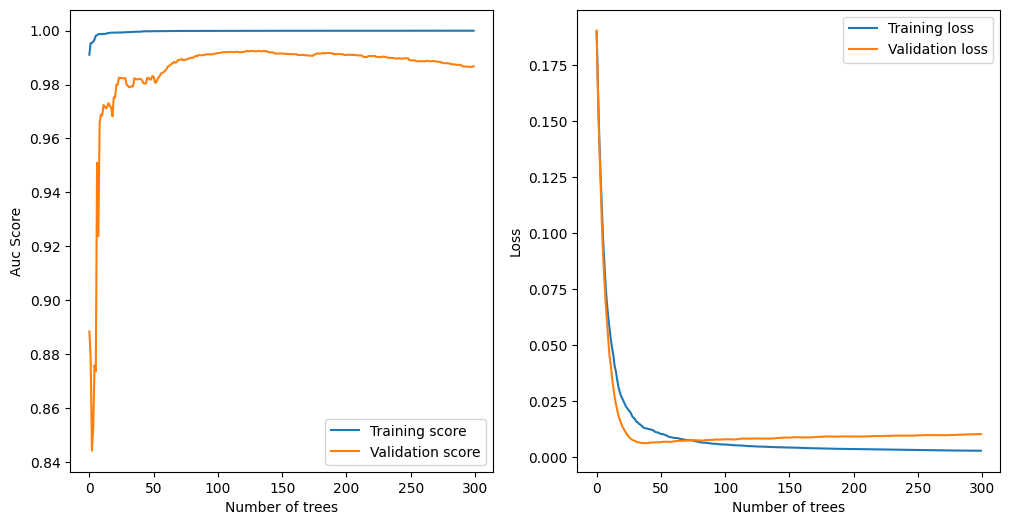

In [53]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax1.plot(results["validation_0"]["auc"], label="Training score")
ax1.plot(results["validation_1"]["auc"], label="Validation score")
ax1.set_xlabel("Number of trees")
ax1.set_ylabel("Auc Score")
ax1.legend()

ax2.plot(results["validation_0"]["logloss"], label="Training loss")
ax2.plot(results["validation_1"]["logloss"], label="Validation loss")
ax2.set_xlabel("Number of trees")
ax2.set_ylabel("Loss")
ax2.legend()

#### *Adding early stopping* in training phase

In [54]:
best_model = XGBClassifier(random_state=SEED, early_stopping_rounds=50, **best_params)
pipeline = get_pipeline(best_model, preprocess())
pipeline

pipeline.fit(
    X_train,
    y_train,
    xgbclassifier__eval_set=[(X_train_transformed, y_train), (X_test_transformed, y_test)],
    xgbclassifier__eval_metric=['auc', 'logloss']
)

[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   1.3s
[0]	validation_0-auc:0.99105	validation_0-logloss:0.19007	validation_1-auc:0.88835	validation_1-logloss:0.19040
[1]	validation_0-auc:0.99537	validation_0-logloss:0.16499	validation_1-auc:0.87850	validation_1-logloss:0.16303
[2]	validation_0-auc:0.99545	validation_0-logloss:0.14400	validation_1-auc:0.84410	validation_1-logloss:0.14021
[3]	validation_0-auc:0.99593	validation_0-logloss:0.12712	validation_1-auc:0.85283	validation_1-logloss:0.12380
[4]	validation_0-auc:0.99670	validation_0-logloss:0.11175	validation_1-auc:0.87576	validation_1-logloss:0.10529
[5]	validation_0-auc:0.99812	validation_0-logloss:0.09752	validation_1-auc:0.87361	validation_1-logloss:0.09014
[6]	validation_0-auc:0.99832	validation_0-logloss:0.08681	validation_1-auc:0.95097	validation_1-logloss:0.07981
[7]	validation_0-auc:0.99869	validation_0-logloss:0.07633	validation_1-auc:0.92372	validation_1-logloss:0.06858
[8]	validation_0-auc:0.99872	vali

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x359247160>),
                                                                  ('pipeline',
                                                                   Pipeline(steps=[('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compos...
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.15016461442678056, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=300,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))],
         verbose=True)

In [55]:
best_iteration = pipeline.named_steps['xgbclassifier'].best_iteration
best_iteration

37

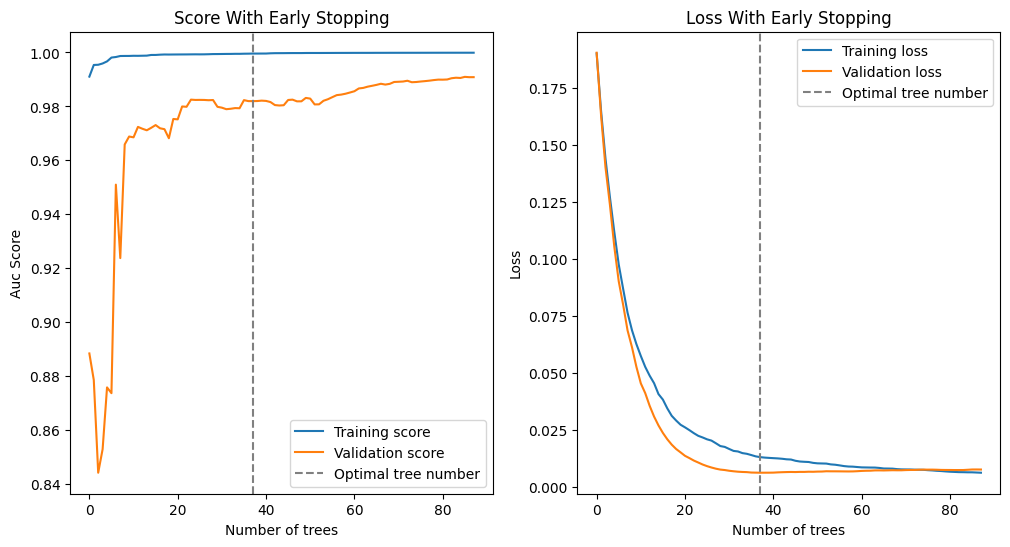

In [56]:
results_es = pipeline.named_steps['xgbclassifier'].evals_result()
results_es

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax1.plot(results_es["validation_0"]["auc"], label="Training score")
ax1.plot(results_es["validation_1"]["auc"], label="Validation score")
ax1.set_xlabel("Number of trees")
ax1.set_ylabel("Auc Score")
ax1.axvline(best_iteration, color="gray", label="Optimal tree number", linestyle='--')
ax1.set_title('Score With Early Stopping')
ax1.legend()

ax2.plot(results_es["validation_0"]["logloss"], label="Training loss")
ax2.plot(results_es["validation_1"]["logloss"], label="Validation loss")
ax2.set_xlabel("Number of trees")
ax2.set_ylabel("Loss")
ax2.axvline(best_iteration, color="gray", label="Optimal tree number", linestyle='--')
ax2.set_title('Loss With Early Stopping')
ax2.legend()


plt.show()

In [57]:
pipeline.predict(X_test, iteration_range=(0, best_iteration + 1))

array([0, 0, 1, ..., 0, 0, 0])

### Evaluation and Adjustong Decision Thresholds

In [58]:
y_pred = pipeline.predict(X_test)

In [59]:
# Best model performance
display_performance(pipeline, X_test, y_test, model_name='XGBoost')

,Accuracy,Recall,Roc_Auc,Precision,F1 Score
XGBoost,0.9953,0.9922,0.9938,0.2146,0.3529


0.9953044500535942

[[1581149    7453]
 [     16    2037]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.21      0.99      0.35      2053

    accuracy                           1.00   1590655
   macro avg       0.61      0.99      0.68   1590655
weighted avg       1.00      1.00      1.00   1590655



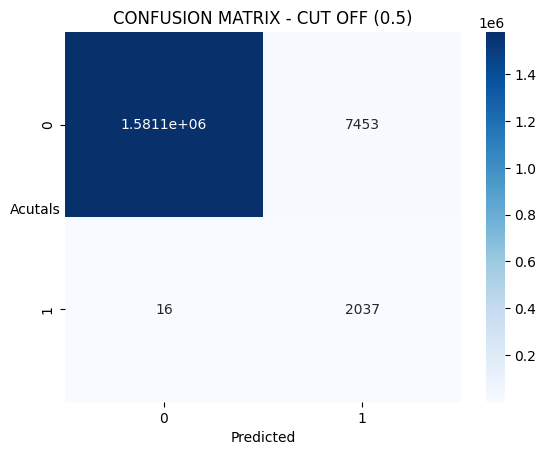

In [60]:
model_score = pipeline.score(X_test, y_test)
display_model_result(y_test, y_pred, model_score)
plot_confusion_matrix(y_test, y_pred)

In [61]:
# Predict probabilities
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred_proba

array([5.1043709e-03, 7.4983935e-04, 6.7564183e-01, ..., 6.3700241e-04,
       6.6945609e-04, 1.0220429e-03], dtype=float32)

In [62]:
# Adjust the decision threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores

array([0.002578  , 0.002578  , 0.002578  , ..., 0.27115789, 0.0335249 ,
       0.        ])

In [68]:
# Predict with the best threshold
best_threshold = thresholds[np.argmax(f1_scores)]
best_threshold
y_pred = (y_pred_proba >= best_threshold).astype(int)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
pr_auc = auc(recall, precision)
print(f"Best Decision Threshold: {best_threshold}")
print(f"ROC AUC: {roc_auc}")
print(f'Precision-Recall AUC: {pr_auc}')
print(f"F1 Score: {f1}")

Best Decision Threshold: 0.9404857158660889
ROC AUC: 0.9995227166110061
Precision-Recall AUC: 0.8995715085288797
F1 Score: 0.8425925925925926


In [70]:
scores = pd.DataFrame({'thresholds': thresholds, 'precision': precision[:-1], 'recall': recall[:-1]})
scores

,thresholds,precision,recall
0,0.000424,0.001291,1.000000
1,0.000445,0.001291,1.000000
2,0.000463,0.001291,1.000000
3,0.000472,0.001291,1.000000
4,0.000472,0.001291,1.000000
...,...,...,...
36916,0.996248,1.000000,0.258159
36917,0.996311,1.000000,0.246469
36918,0.996313,1.000000,0.224549
36919,0.996578,1.000000,0.156844


Text(0.5, 0, 'recall')

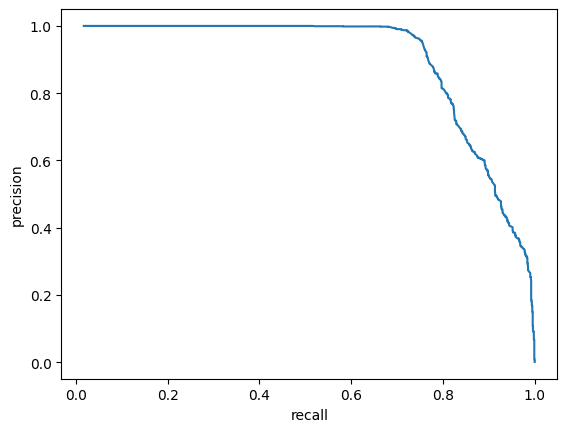

In [71]:
plt.plot(scores['recall'], scores['precision'])
plt.ylabel('precision')
plt.xlabel('recall')

In [76]:
# Threshold that guaramtees 0.8 recall score
scores[scores['recall'] >= 0.8].thresholds.max()

0.8817413

### Ensemble and prediction

In [ ]:
# class CombinedModel(BaseEstimator, ClassifierMixin):
    
#     def __init__(self, model1, model2):
#         self.model1 = model1
#         self.model2 = model2
        
    
#     def fit(self, X, y):
#         self.model1.fit(X, y)
#         self.model2.fit(X, y)
#         return self
    
#     def predict(self, X):
#         pred1 = self.model1.predict(X)
#         pred2 = self.model2.predict(X)
#         combined_pred = (pred1 + pred2) // 2
#         return combined_pred
    
    
#     def predict_proba(self, X):
#         prob1 = self.model1.predict_proba(X)
#         prob2 = self.model2.predict_proba(X)
#         combined_prob = (prob1 + prob2) / 2
#         return combined_prob

In [ ]:
# xgb_model = XGBClassifier(**xbg_study.best_params)
# rf_model = rf_search.best_estimator_

In [ ]:
# combined_model = CombinedModel(xgb_model, rf_model)
# combined_model.fit(X_train_resampled, y_train_resampled)
# y_pred = combined_model.predict(X_test)